![director](images/director_shot.jpeg)

# Microsoft Film Analysis
***
**Author:** Laura Miller

## Overview
***
Microsoft wishes to launch their own movie studio. This project employs a descriptive analysis of film data to determine what factors have contributed to successful releases in the past. The company will benefit from informed recommendations on getting started, including how much to initially spend, when to release content, who to hire to direct and act in their films, and what film genres they should explore. 

## Business Problem
***
Microsoft wants to break into the business of creating original video content, yet they lack experience in this industry. This analysis attempts to answer the following questions:
- How much should you spend to make a successful movie?
- What are the best months for a movie release?
- What genres have the highest ROI?
- Which actors and directors bring the most value to a film?

## Data
***
All datasets used in this project come from The Numbers and IMDB.

**The Numbers**
- `Movie Budgets`: Budget and gross information for 5782 films, dating back to 1916

**IMDB**
- `Title Basics`: Genre information for various films, organized by title id
- `Title Principals`: Person ids, roles (actors, actresses, and directors), and associated titles
- `Name Basics`: Person ids and corresponding names

## Question 1: How much should you spend to make a successful movie?
***
This portion of the analysis was done with the data in `Movie Budgets`. After determining there were no duplicate entries, I cleaned the data by reformatting the monetary data and changing some datatypes. I removed dollar signs and commas from monetary columns and converted their datatype from `object` to `int`. I also converted release date data to date-time objects, from which I extracted the year to create a `release_year` column. 

The next step was to adjust for inflation (in `budget`, `worldwide_gross`, and `domestic_gross`), as I was dealing with historical monetary data. This was done with the CPI library and the following code:

`movie_budgets_df['budget_adjusted'] = movie_budgets_df.apply(lambda x: cpi.inflate(x.production_budget,   x.release_year), axis=1)`

I then calculated the domestic and worldwide return on investment (ROI), creating new columns for each:

`movie_budgets_df['roi'] = (movie_budgets_df['wwgross_adjusted'] - movie_budgets_df['budget_adjusted']) / movie_budgets_df['budget_adjusted']`

I wanted to create a new categorical variable, budget classes, for my spending analysis, and used the `qcut` method for this:

`bin_labels = ['Low', 'Low Medium', 'High Medium', 'High']
budgets_adjusted_df['budget_class'] = pd.qcut(budgets_adjusted_df['budget_adjusted'], q=[0, 0.25, 0.5, 0.75, 1],   labels=bin_labels, precision=0)`

This gave me 4 budget classes:

- **Low**: 1,000 - 7,800,000
- **Low Medium**: 7.8 - 24 million
- **High Medium**: 24 - 58 million
- **High**: 58 million + (up to 513 million)

At this point, I created two new columns for domestic and worldwide profits. This calculation is just the dividend from the ROI formula (the difference between budget and domestic/worldwide gross).

**In summation**: I adjusted for inflation, added new columns for domestic and worldwide profits and ROI, and created some budget classes. Then I proceeded with my visualizations.

### Overall profit v. budget trend
There is a generally positive trend between money spent and money to be made.

<div>
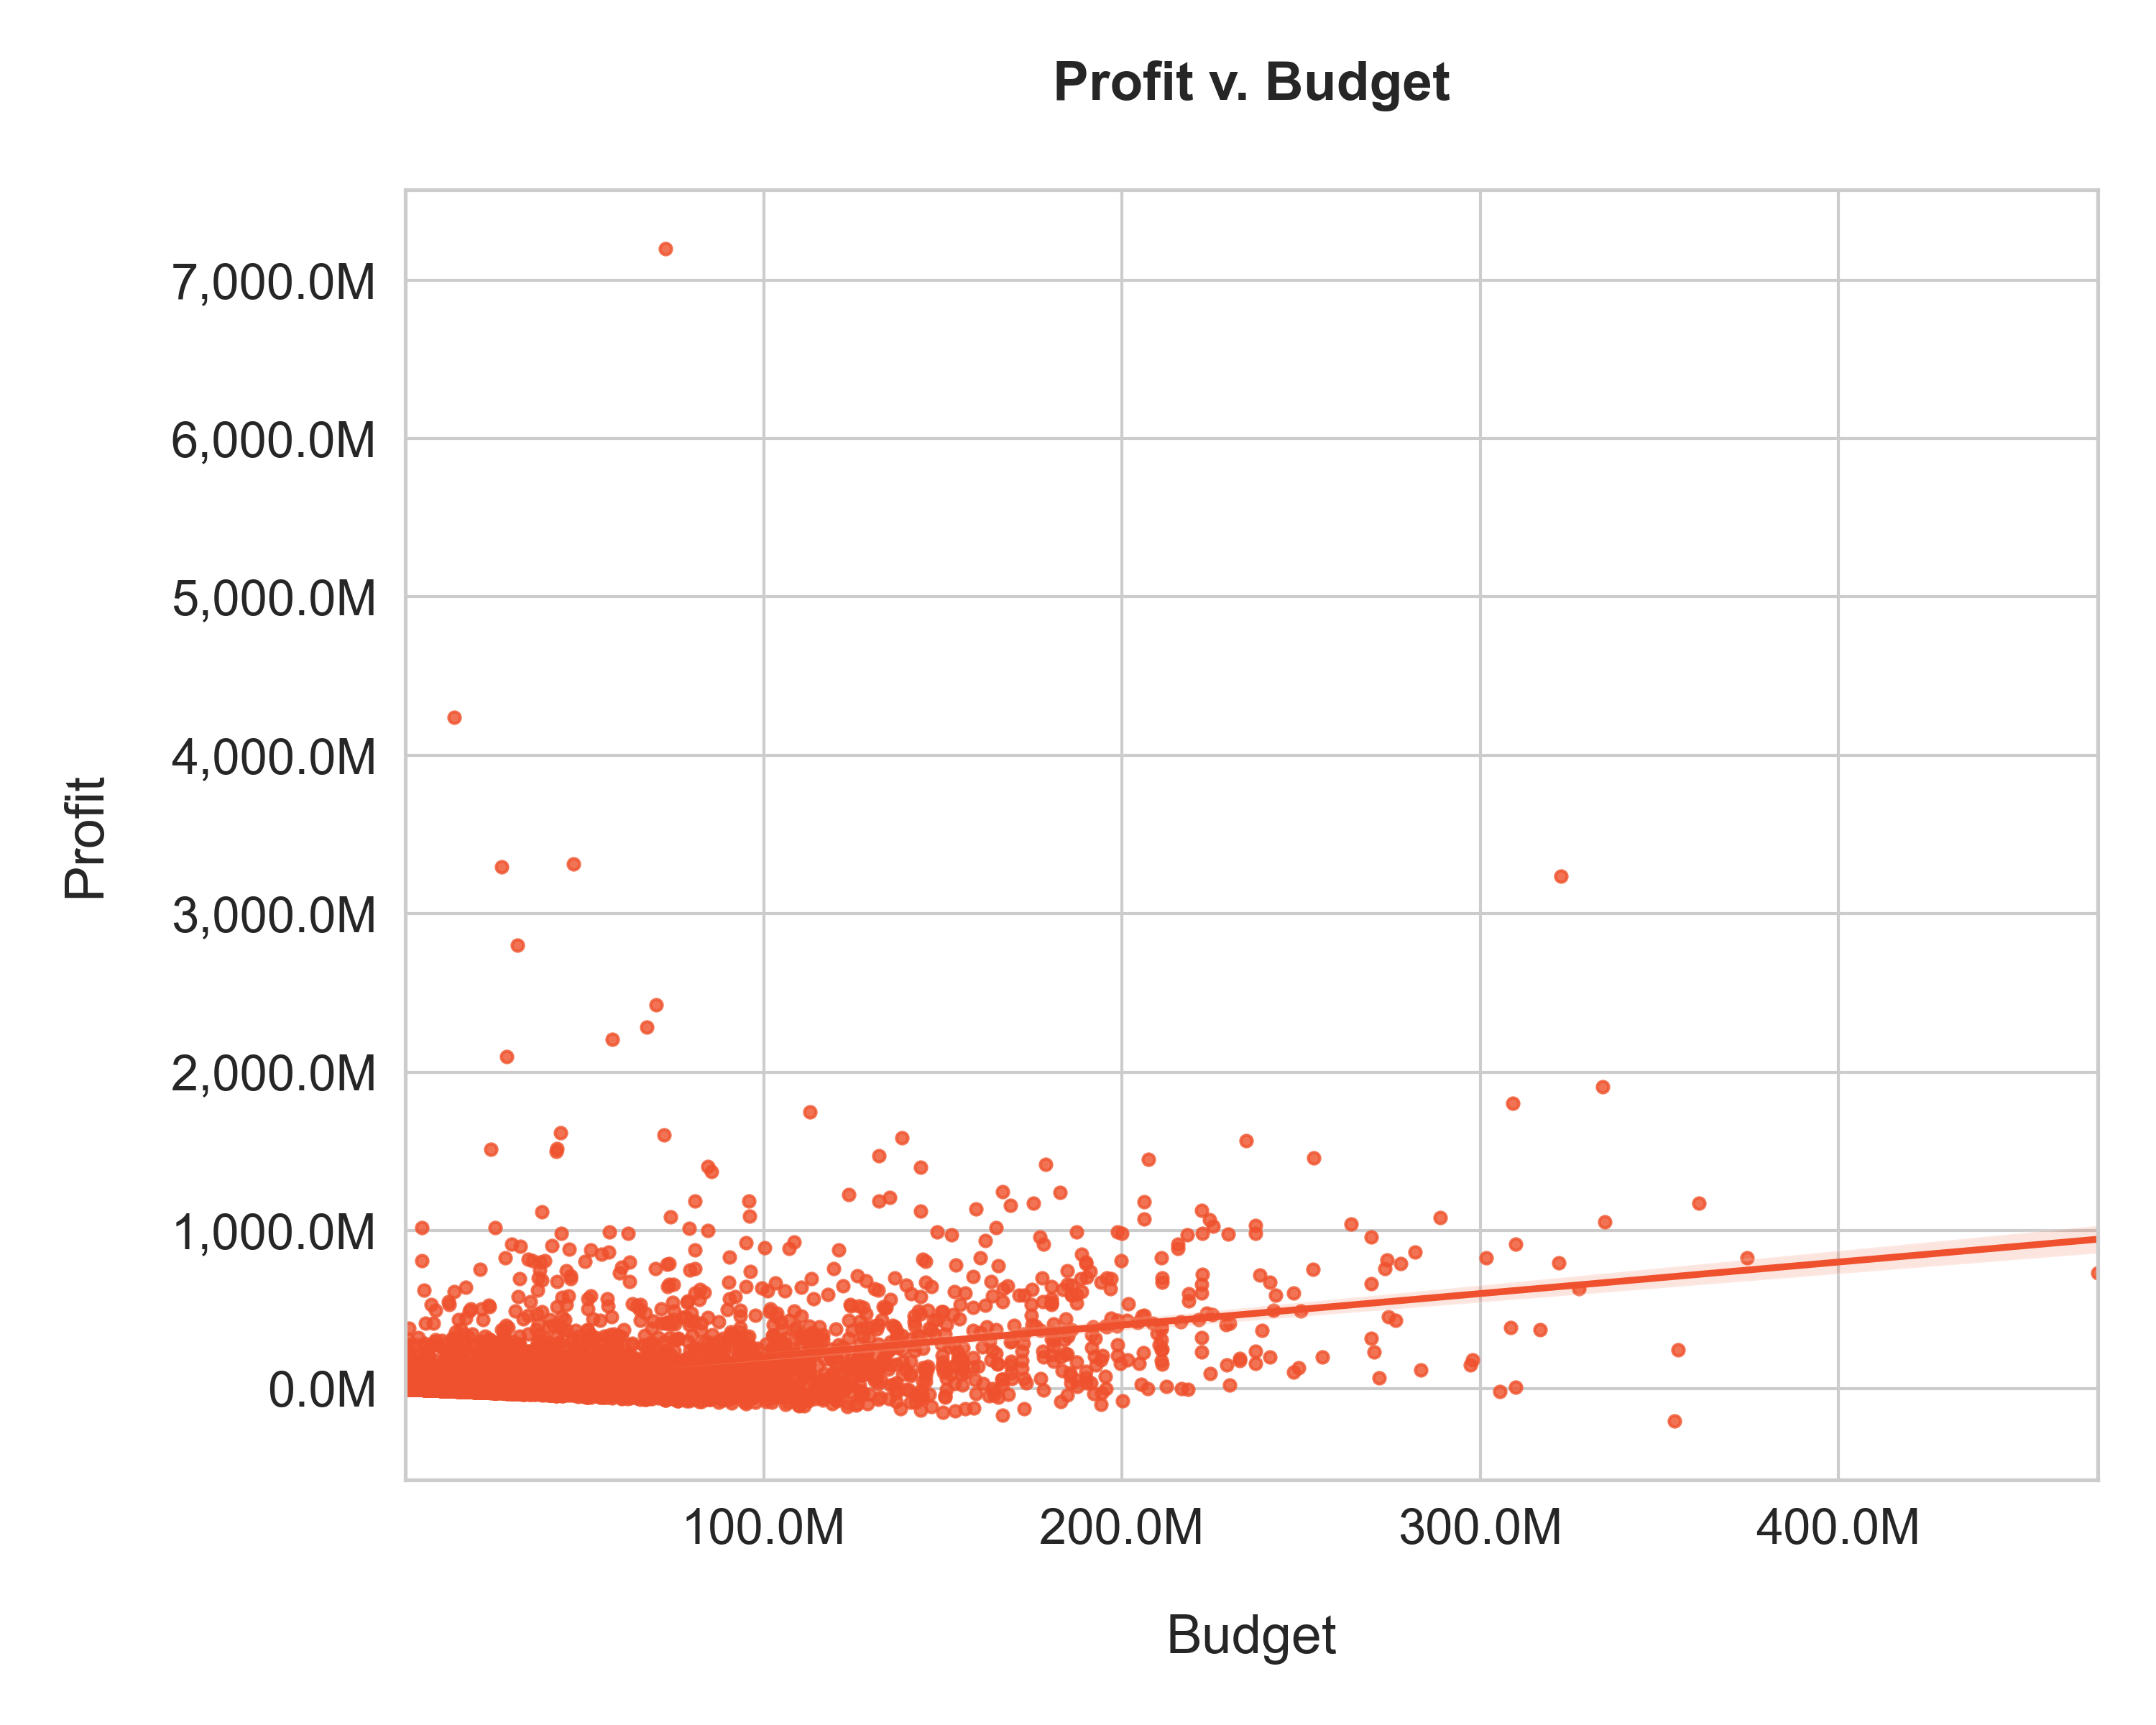
</div>

### Profits and ROI by Budget Class
High Medium Budget films (24-58 million) make more money domestically, while High Budget films (58 million +) yield greater profits worldwide.

<div>
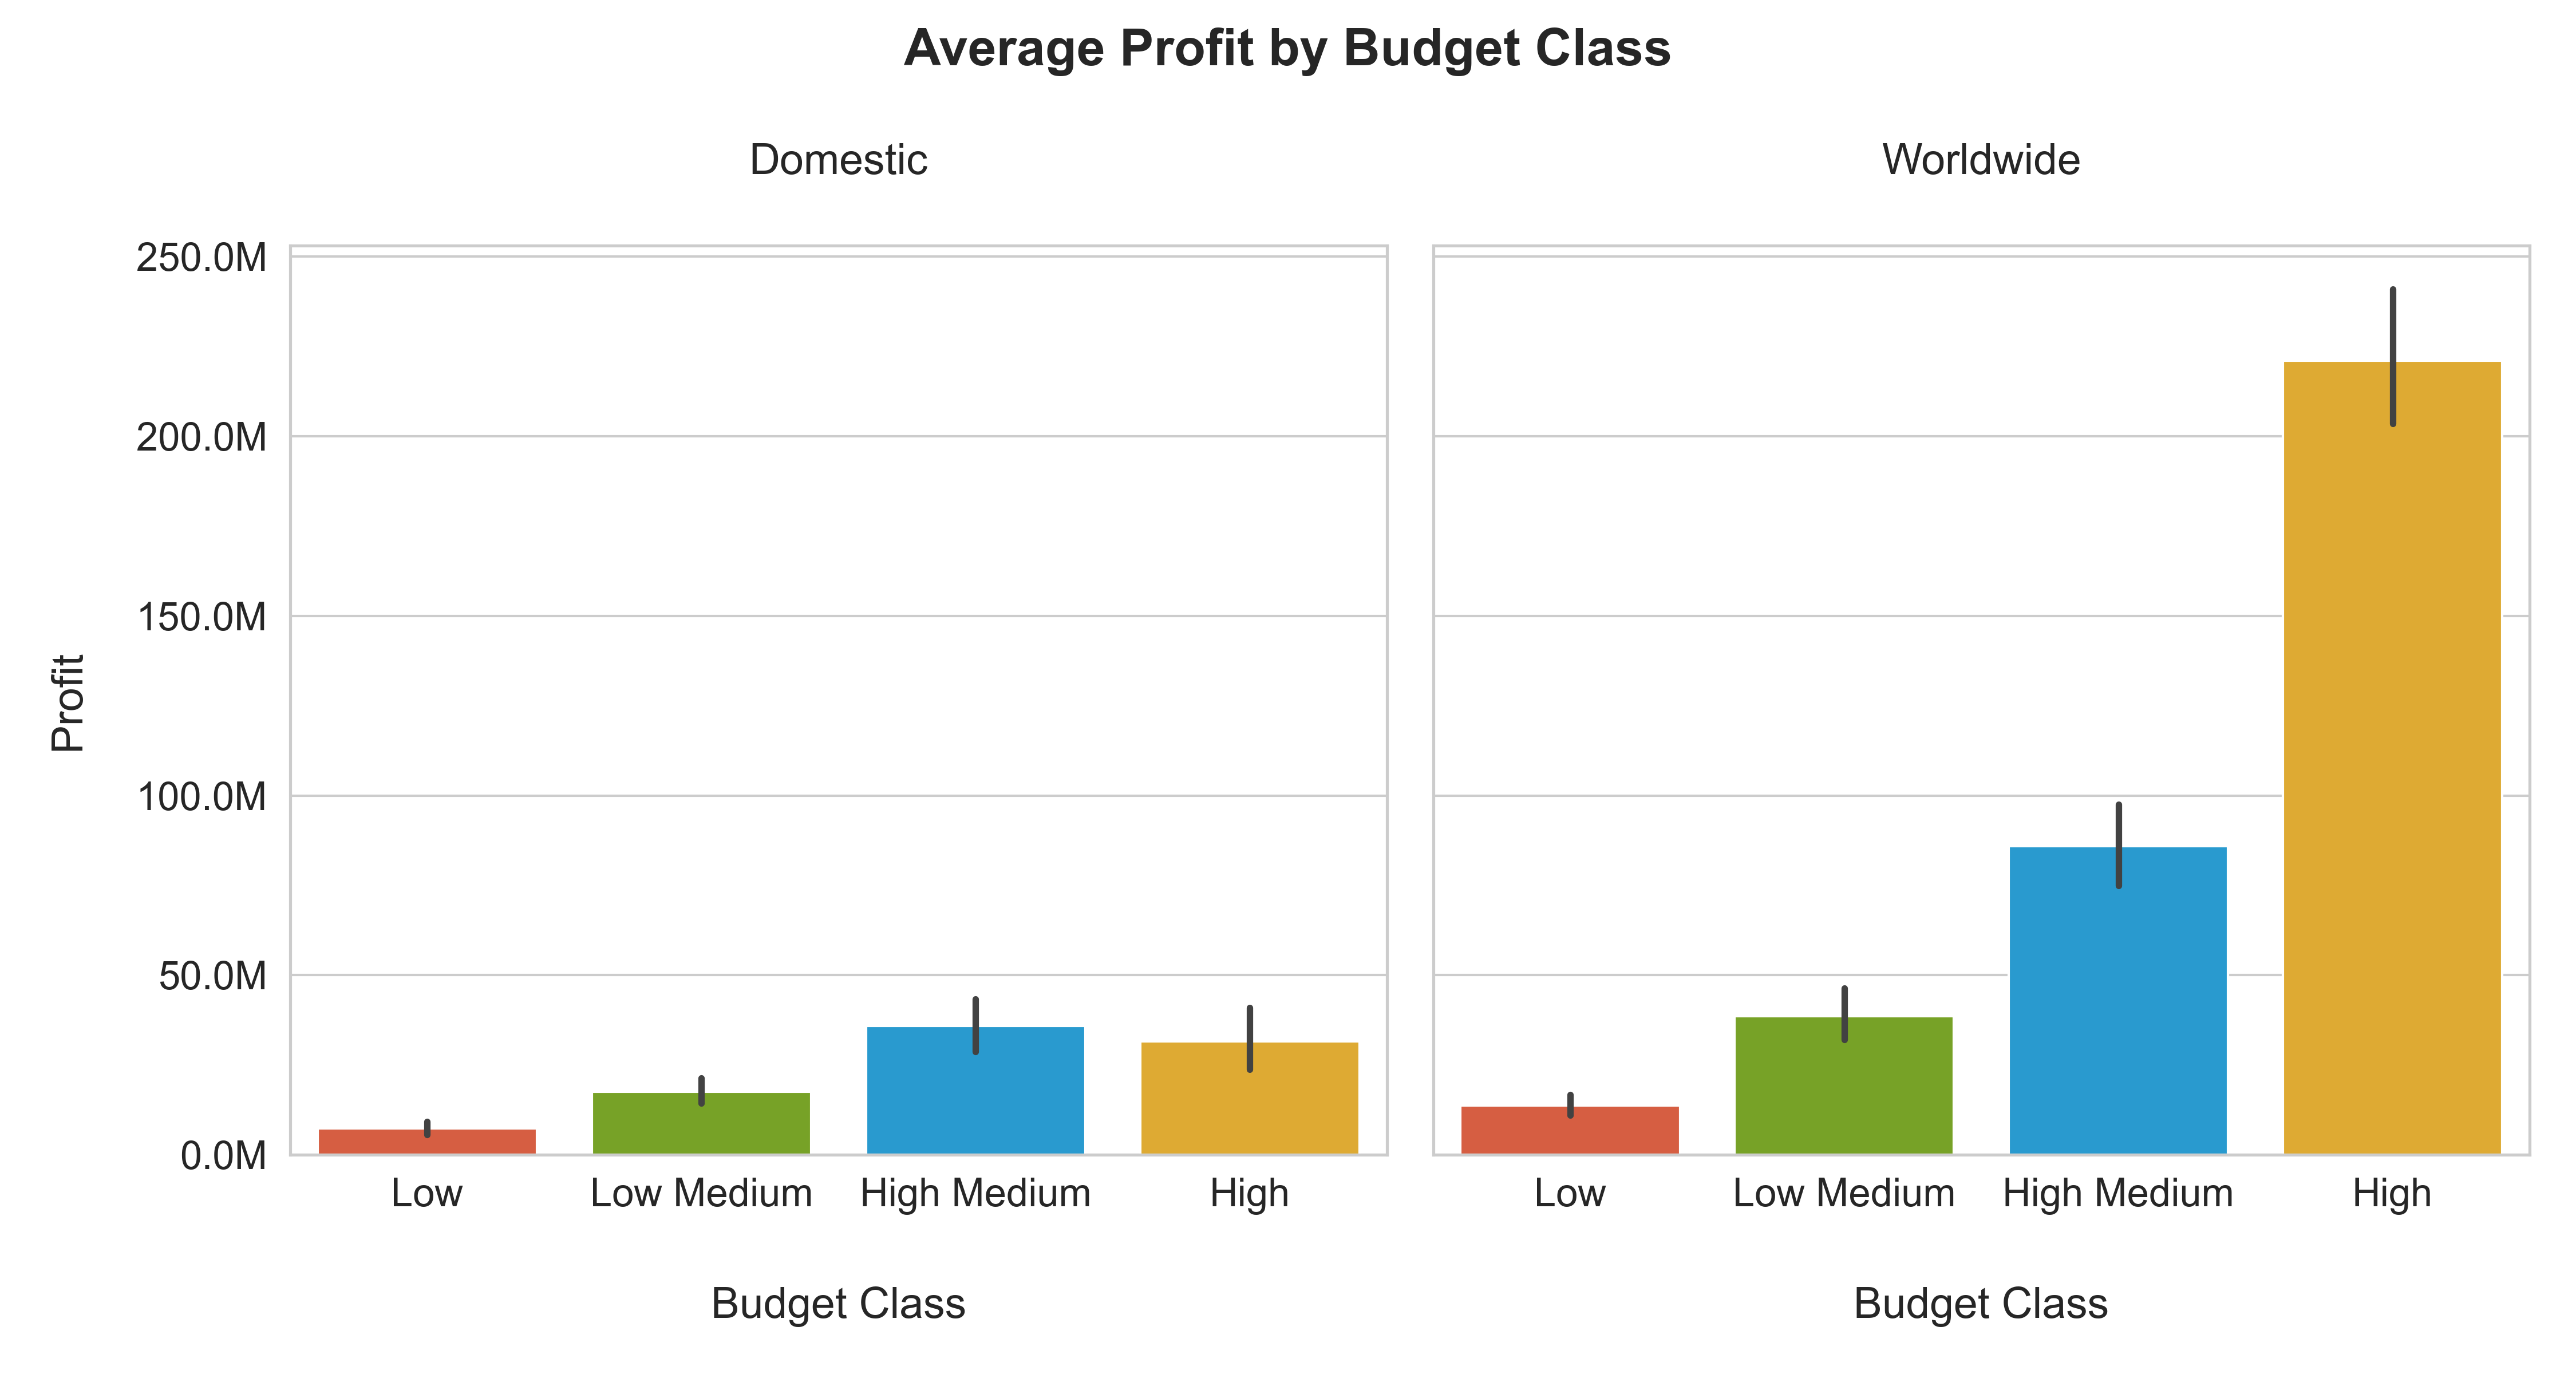
</div>

Low Budget films have the highest ROI, on average, but the data is quite spread out.

<div>
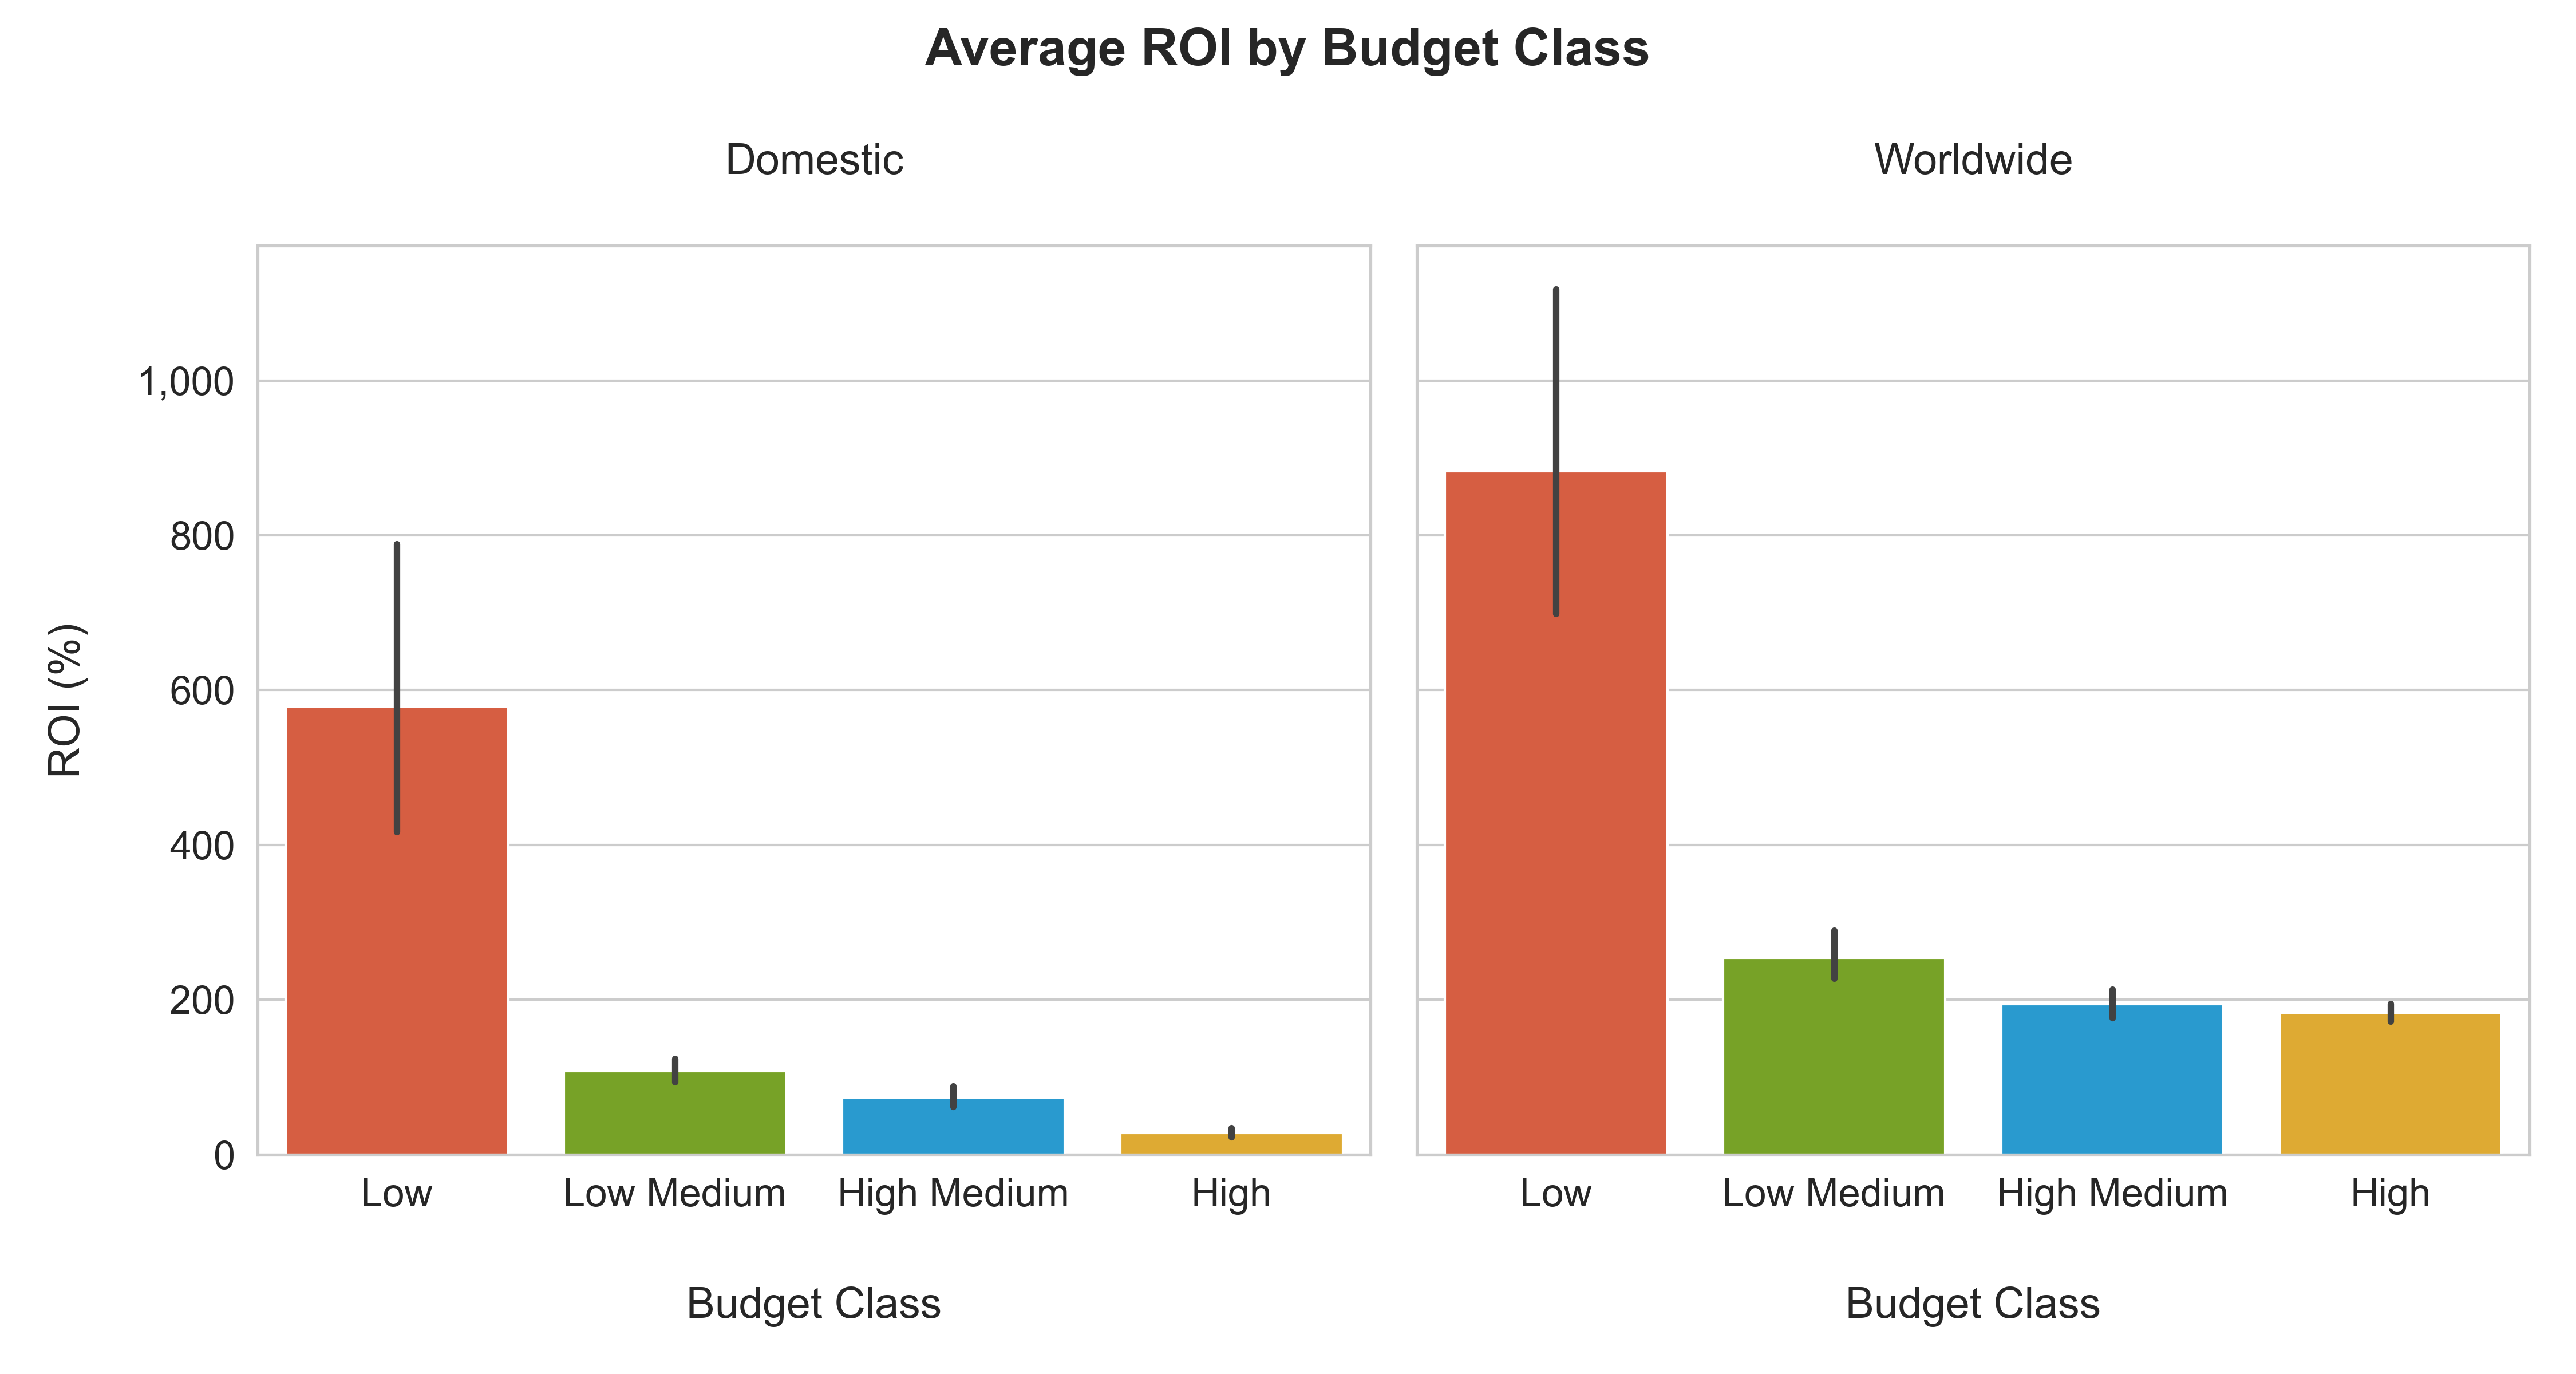
</div>

A boxplot showing the distribution of ROI values for each budget class shows that the median ROI for Low Budget films is actually lower than that for other budget classes. **Note**: This plot excludes ROI outliers across all budget classes.

<div>
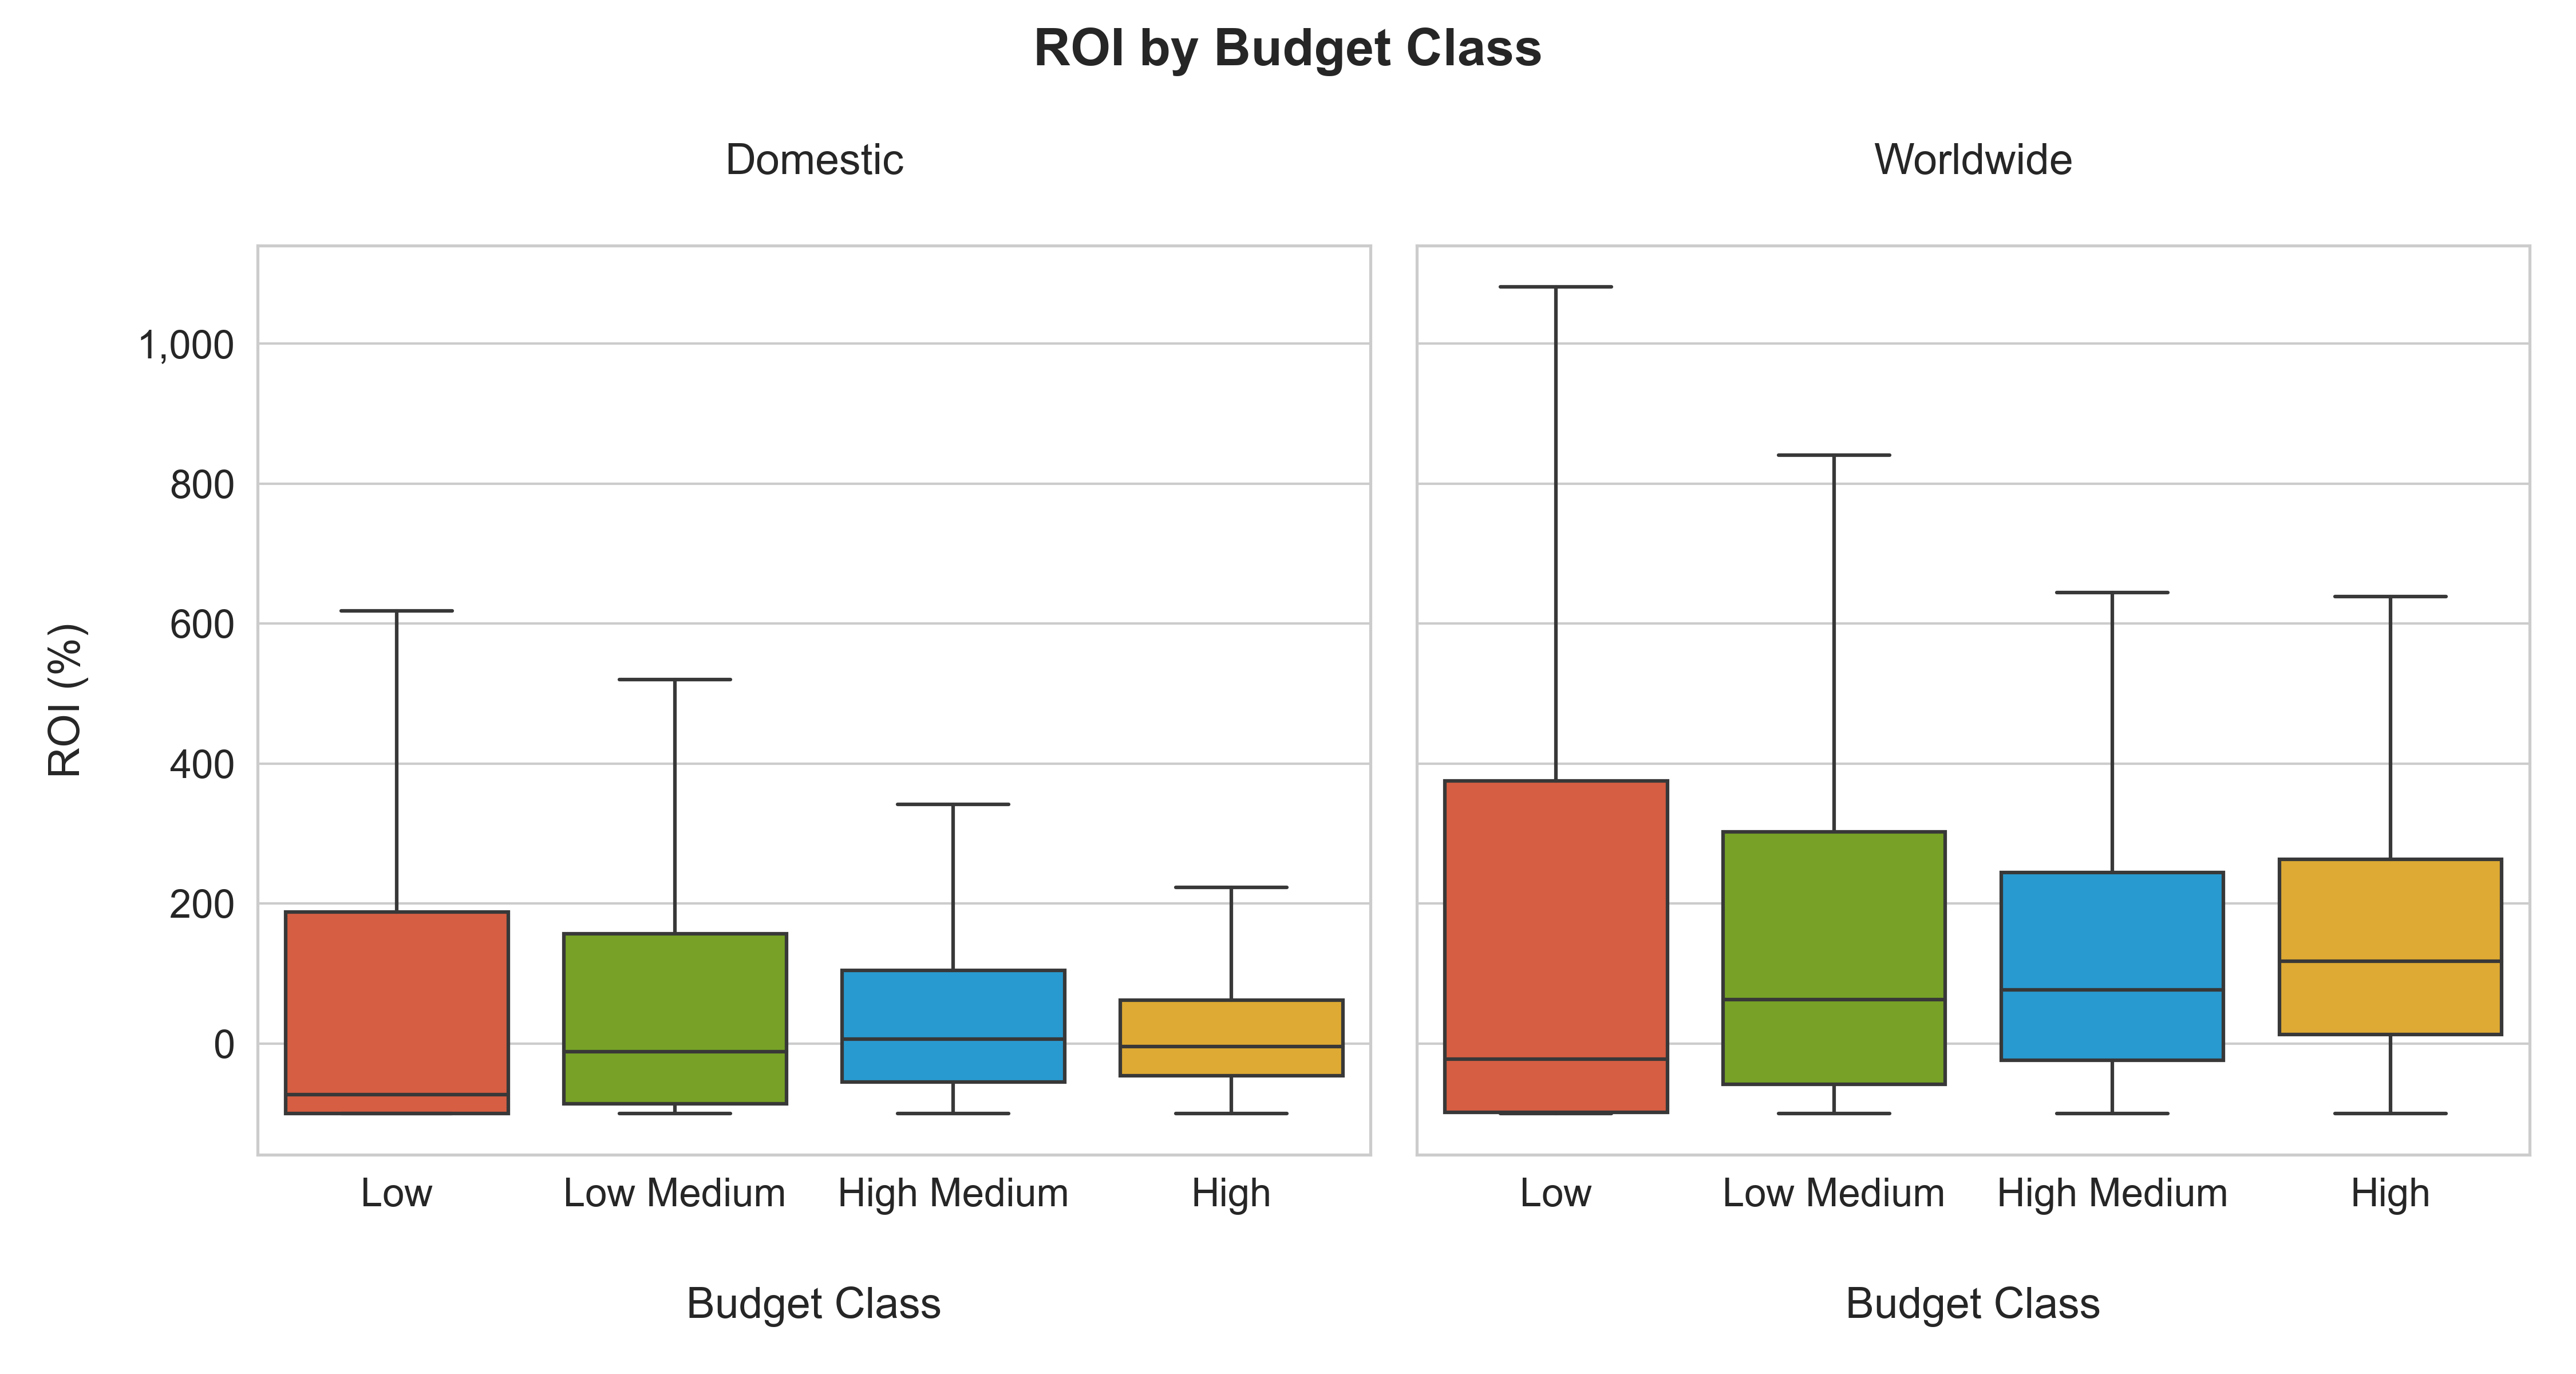
</div>

### Budget recommendations
There is potential to see a higher return on investment from low budget films, but higher budget films will make more money. The sweetspot for entry seems to be the High Medium budget class, especially for domestic releases. For worldwide releases, Microsoft should consider spending upwards of 58 million to rake in the profits. I recommend spending in the High Medium range (24-58 million) to start, and then the High range (58 million +) in the future.

## Outlier Discussion
***
Any performance outliers in this analysis come from `tn_movie_budgets_gz`, as this file contains all the monetary information used in this project. Decisions on what to do with these outliers impact my analyses of other variables, like which genres seem to be the most profitable.

I decided to examine the outliers for both ROI and profit (worldwide), creating separate dataframes for each.
I used the following interquartile range method to acquire a dataframe for these outliers:

`budgets_adjusted_df = budgets_adjusted_df.sort_values(by='profit', ascending=True)`

`Q1 = np.quantile(budgets_adjusted_df['profit'],0.25)
Q3 = np.quantile(budgets_adjusted_df['profit'],0.75)
IQR = Q3 - Q1`

`lower_lim = Q1 - (1.5*IQR)
upper_lim = Q3 + (1.5*IQR)`

`outliers_low = (budgets_adjusted_df['profit'] < lower_lim)
outliers_high = (budgets_adjusted_df['profit'] > upper_lim)
profit_outlier_df = budgets_adjusted_df[outliers_low | outliers_high]`

#### ROI outliers
45% of the ROI outliers come from the Low Budget class. 26% and 19% come from the Low Medium and High Medium classes, respectively. Lower budget films do seem to have higher ROIs, which makes sense given the smaller budgets (smaller divisor in our ROI formula). A boxplot from my preliminary visualization confirms this.

#### Profit outliers
Most of the profit outliers (70%) come from the High Budget category. The mean budget for High Budget profit outliers is around 67 million, so these profit outliers are not necessarily a result of extremely high budgets (the upper end of the High Budget category, which gets up to 513 million).

### Solution for outliers
For the rest of the analysis, I decided to throw out the Low Budget class (under 7.8 million), which contains the bulk of the ROI outliers anyway. I also assumed that Microsoft would risk spending more than 7.8 million on a new film in order to make more money per film. Microsoft would likely be interested in budgets that correlate with higher profits than what low budget films can typically muster up. 

Meanwhile, I decided to include the profit outliers for my remaining questions. The Numbers has made this note on their budget data: "Budget numbers for movies can be both difficult to find and unreliable. Studios and film-makers often try to keep the information secret and will use accounting tricks to inflate or reduce announced budgets" https://www.the-numbers.com/movie/budgets/all. Because it is difficult to tell if the profit outliers are true outliers, and because Microsoft would be interested in what factors may make up an extremely profitable film, I have decided to include them.  

## Question 2: What are the best months for a movie release?
***
I used my cleaned up dataframe from the previous question to find the best months for a movie release in terms of ROI. I also filtered out films that were released before 2000 to account for changes in collective preferences over time. 21 years (2000 to present) is around the average gap between generations. I grouped the data by month and month number, while finding the mean ROI for each month.

ROI surges upward for the summer months of May-July (with peak ROI in July) and again in November.

<div>
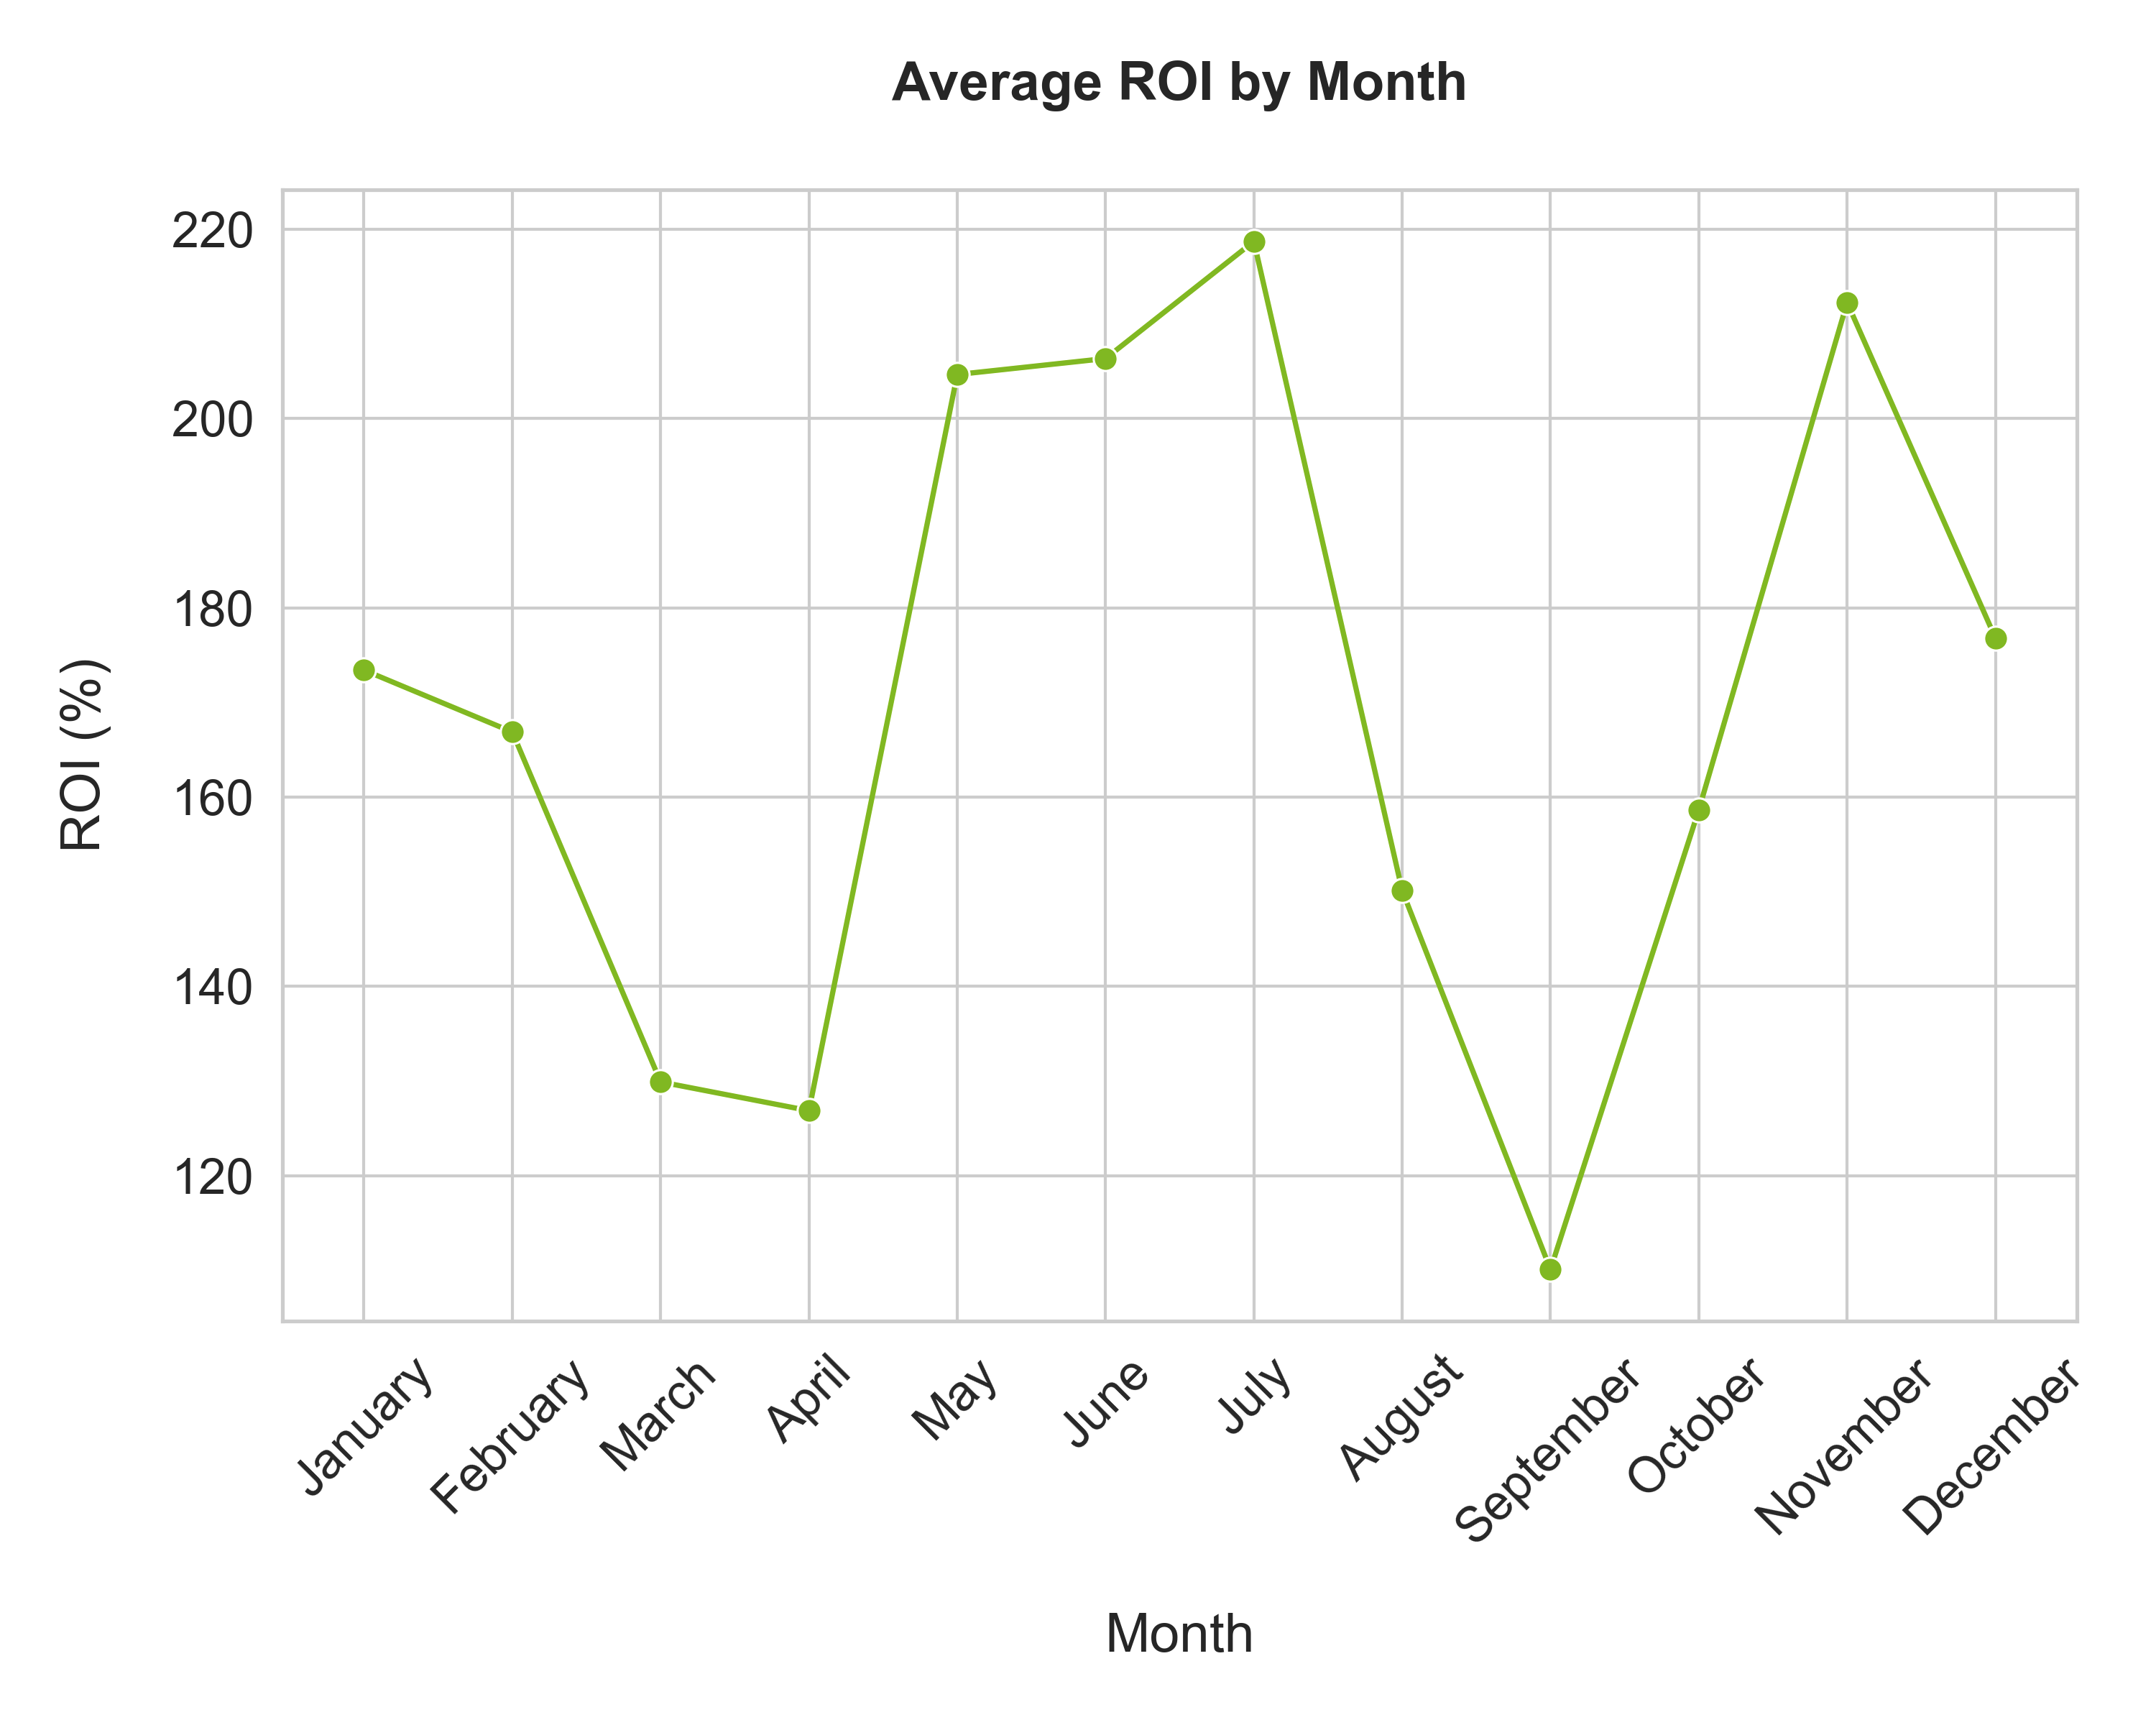
</div>

## Question 3: What genres have the highest ROI?
***
This portion of my analysis required joining my adjusted budget info (`budgets_adjusted_df`) to data from IMDB's `Title Basics`, which contains genre information for different films. I sorted my budget info by ROI (descending), selected the top 100 films, then merged this data with `Title Basics`. I created columns for each genre present in the top 100 and populated these columns with 1s and 0s based on whether a film was of a certain genre. I then found the mean ROI associated with each genre.

The top 3 genres with the highest ROI are Mystery, Horror, and Action.

<div>
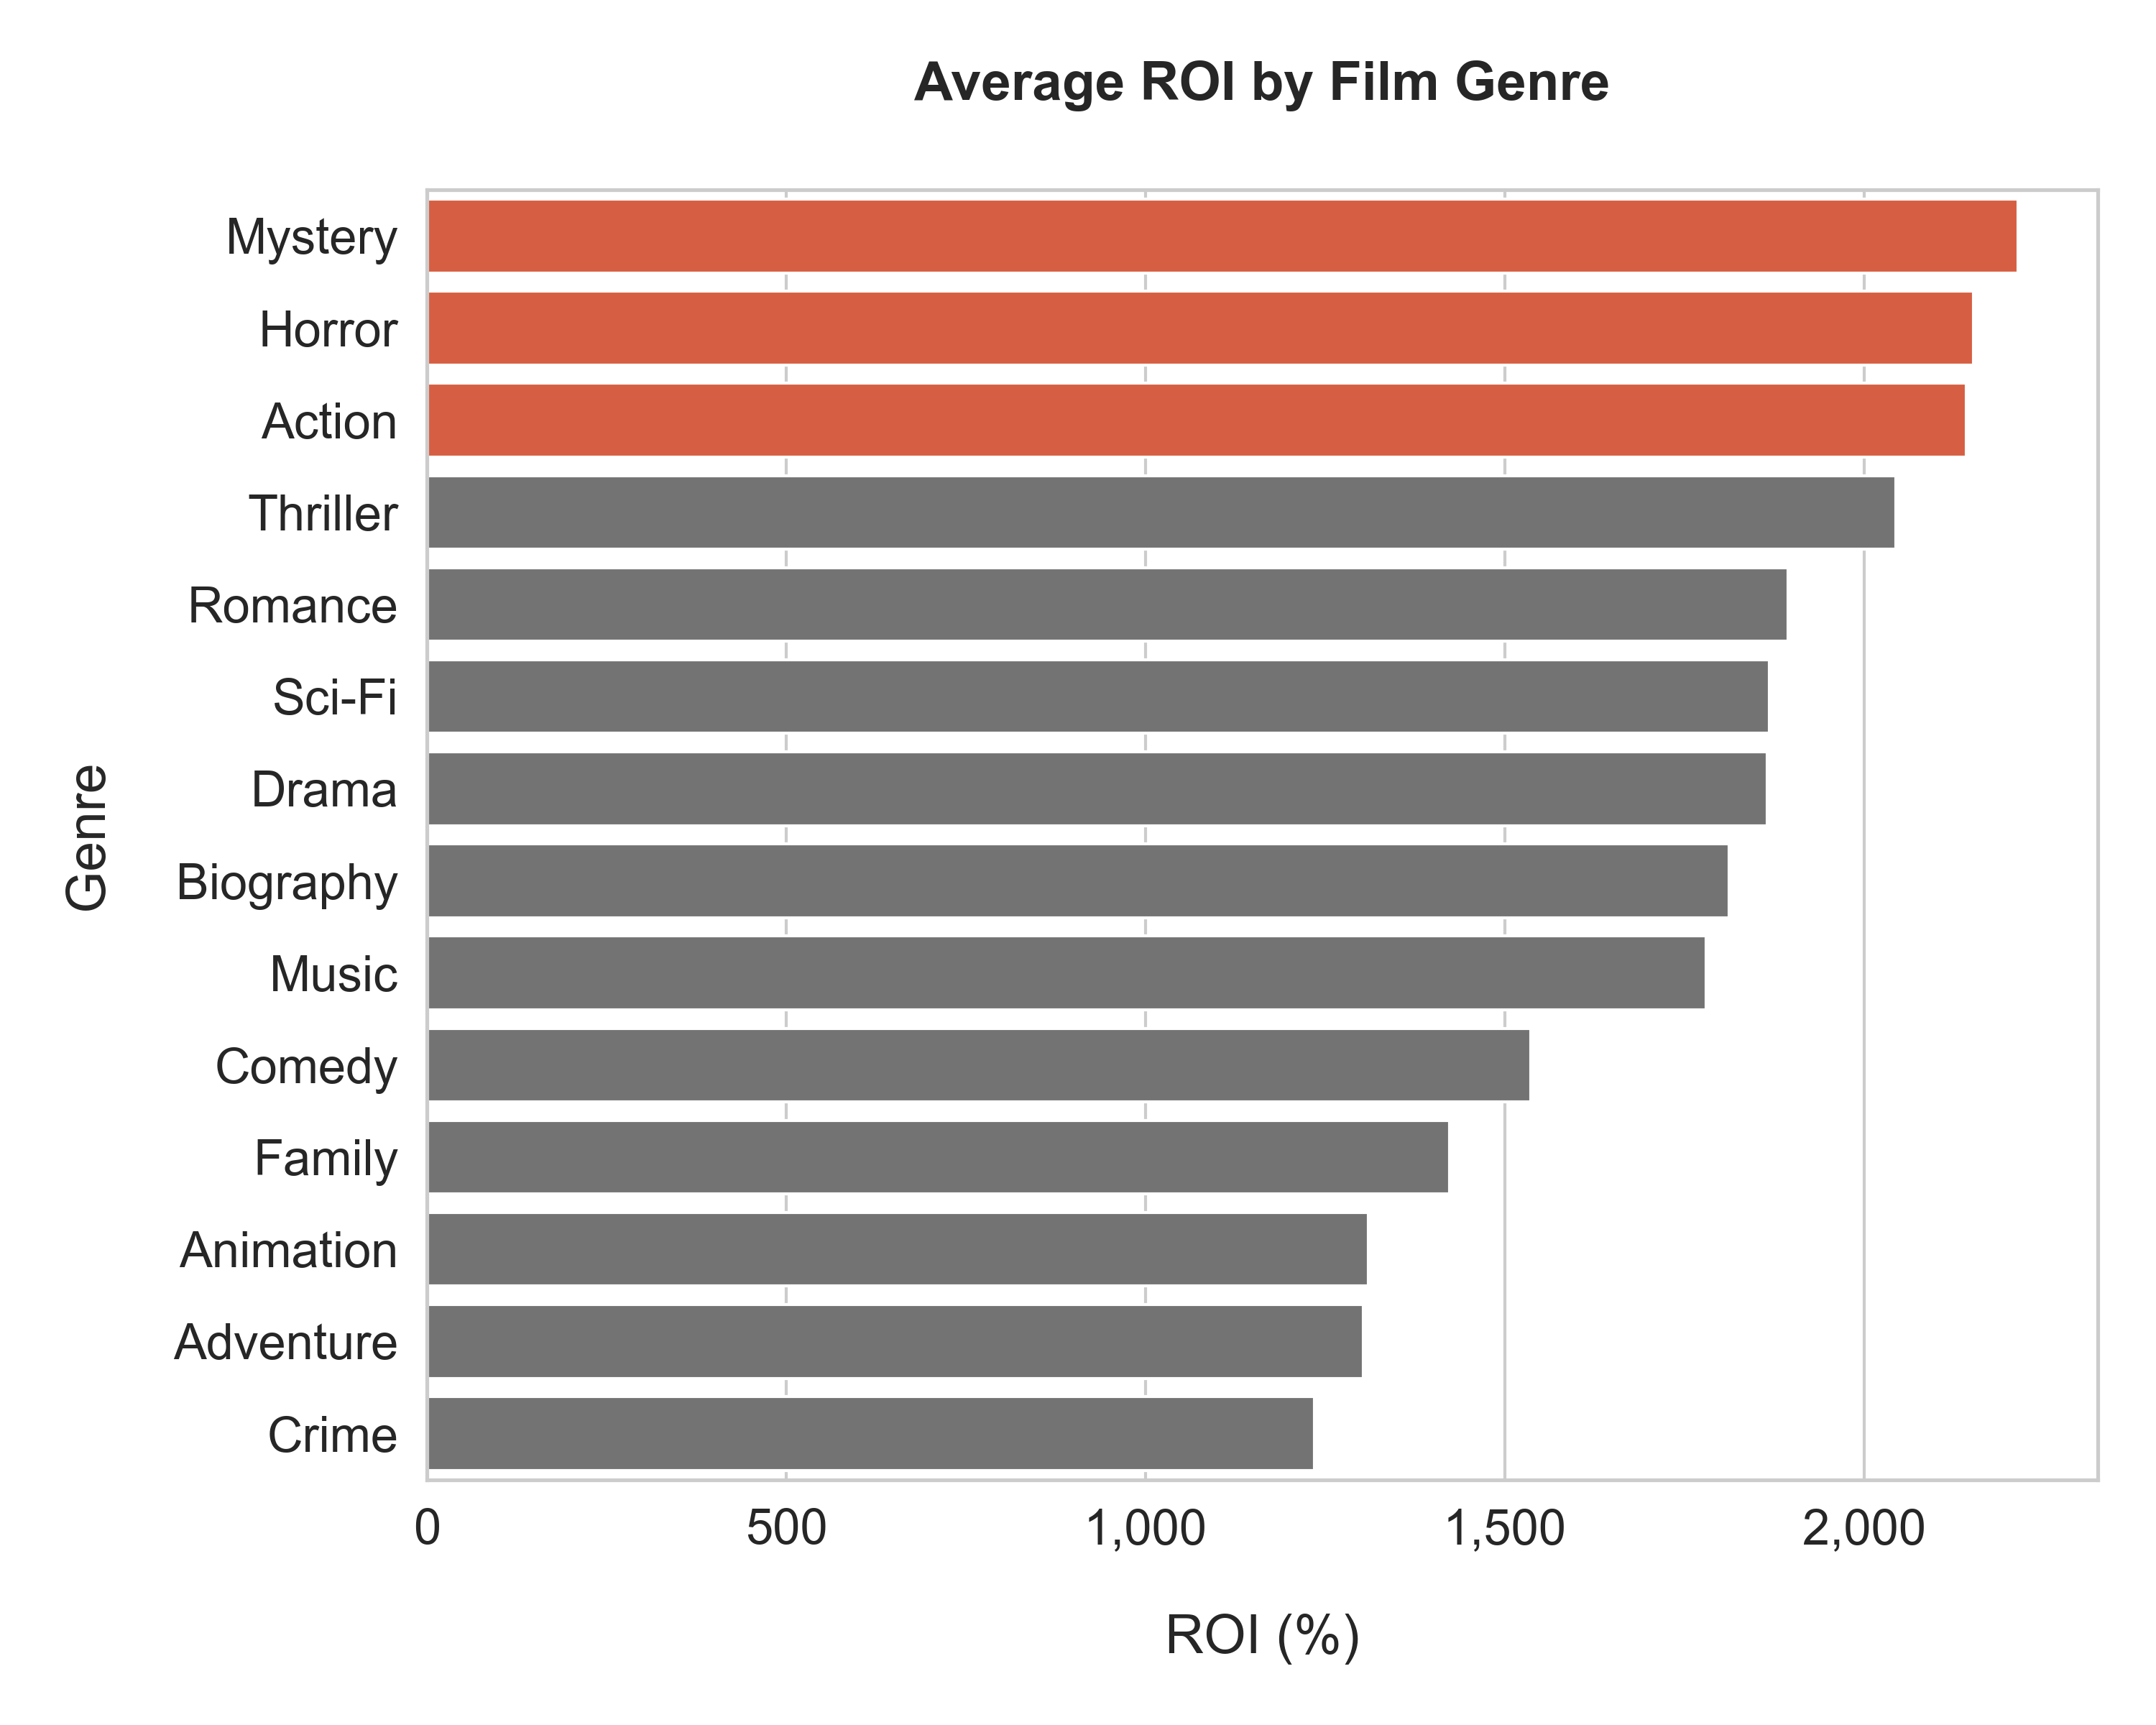
</div>

## Question 4: Which actors and directors bring the most value to a film?

This section required a merge of `Title Principals` and `Name Basics`. `Title Principals` contains cast/crew ids (`nconst`) and title ids (`tconst`) for the the films worked on, while `Name Basics` links a person's name to their `noconst`. I dropped deceased cast/crew members from `Name Basics` first, as Microsoft cannot hire anyone who is dead. From this large dataframe, I created subset dataframes for actors (including actresses) and directors.

I then merged budget/performance info with `Title Basics`. I had done a similar merge in the previous question, but only with the top 100 films. 

The first merge placed principal names and title ids into the same frame, which I then subsetted into actor info and director info. The second merge linked monetary info to title ids. I then merged the actor and director data with the monetary info via the title id field (`tconst`), so that I had actor and director names linked with film performance information (gross figures, budgets, profits, etc). 

#### Actors
I filtered for actors who have appeared in more than 5 films, then found the average ROI of the films they have worked on as a measure of actor value. The expectation of using ROI as a measure was to return actors who may be a little less expensive to work with, but still provide a "bang for your buck." The top 3 actors are Alfre Woodard, Annabelle Wallis, and Anthony LaPaglia.

<div>
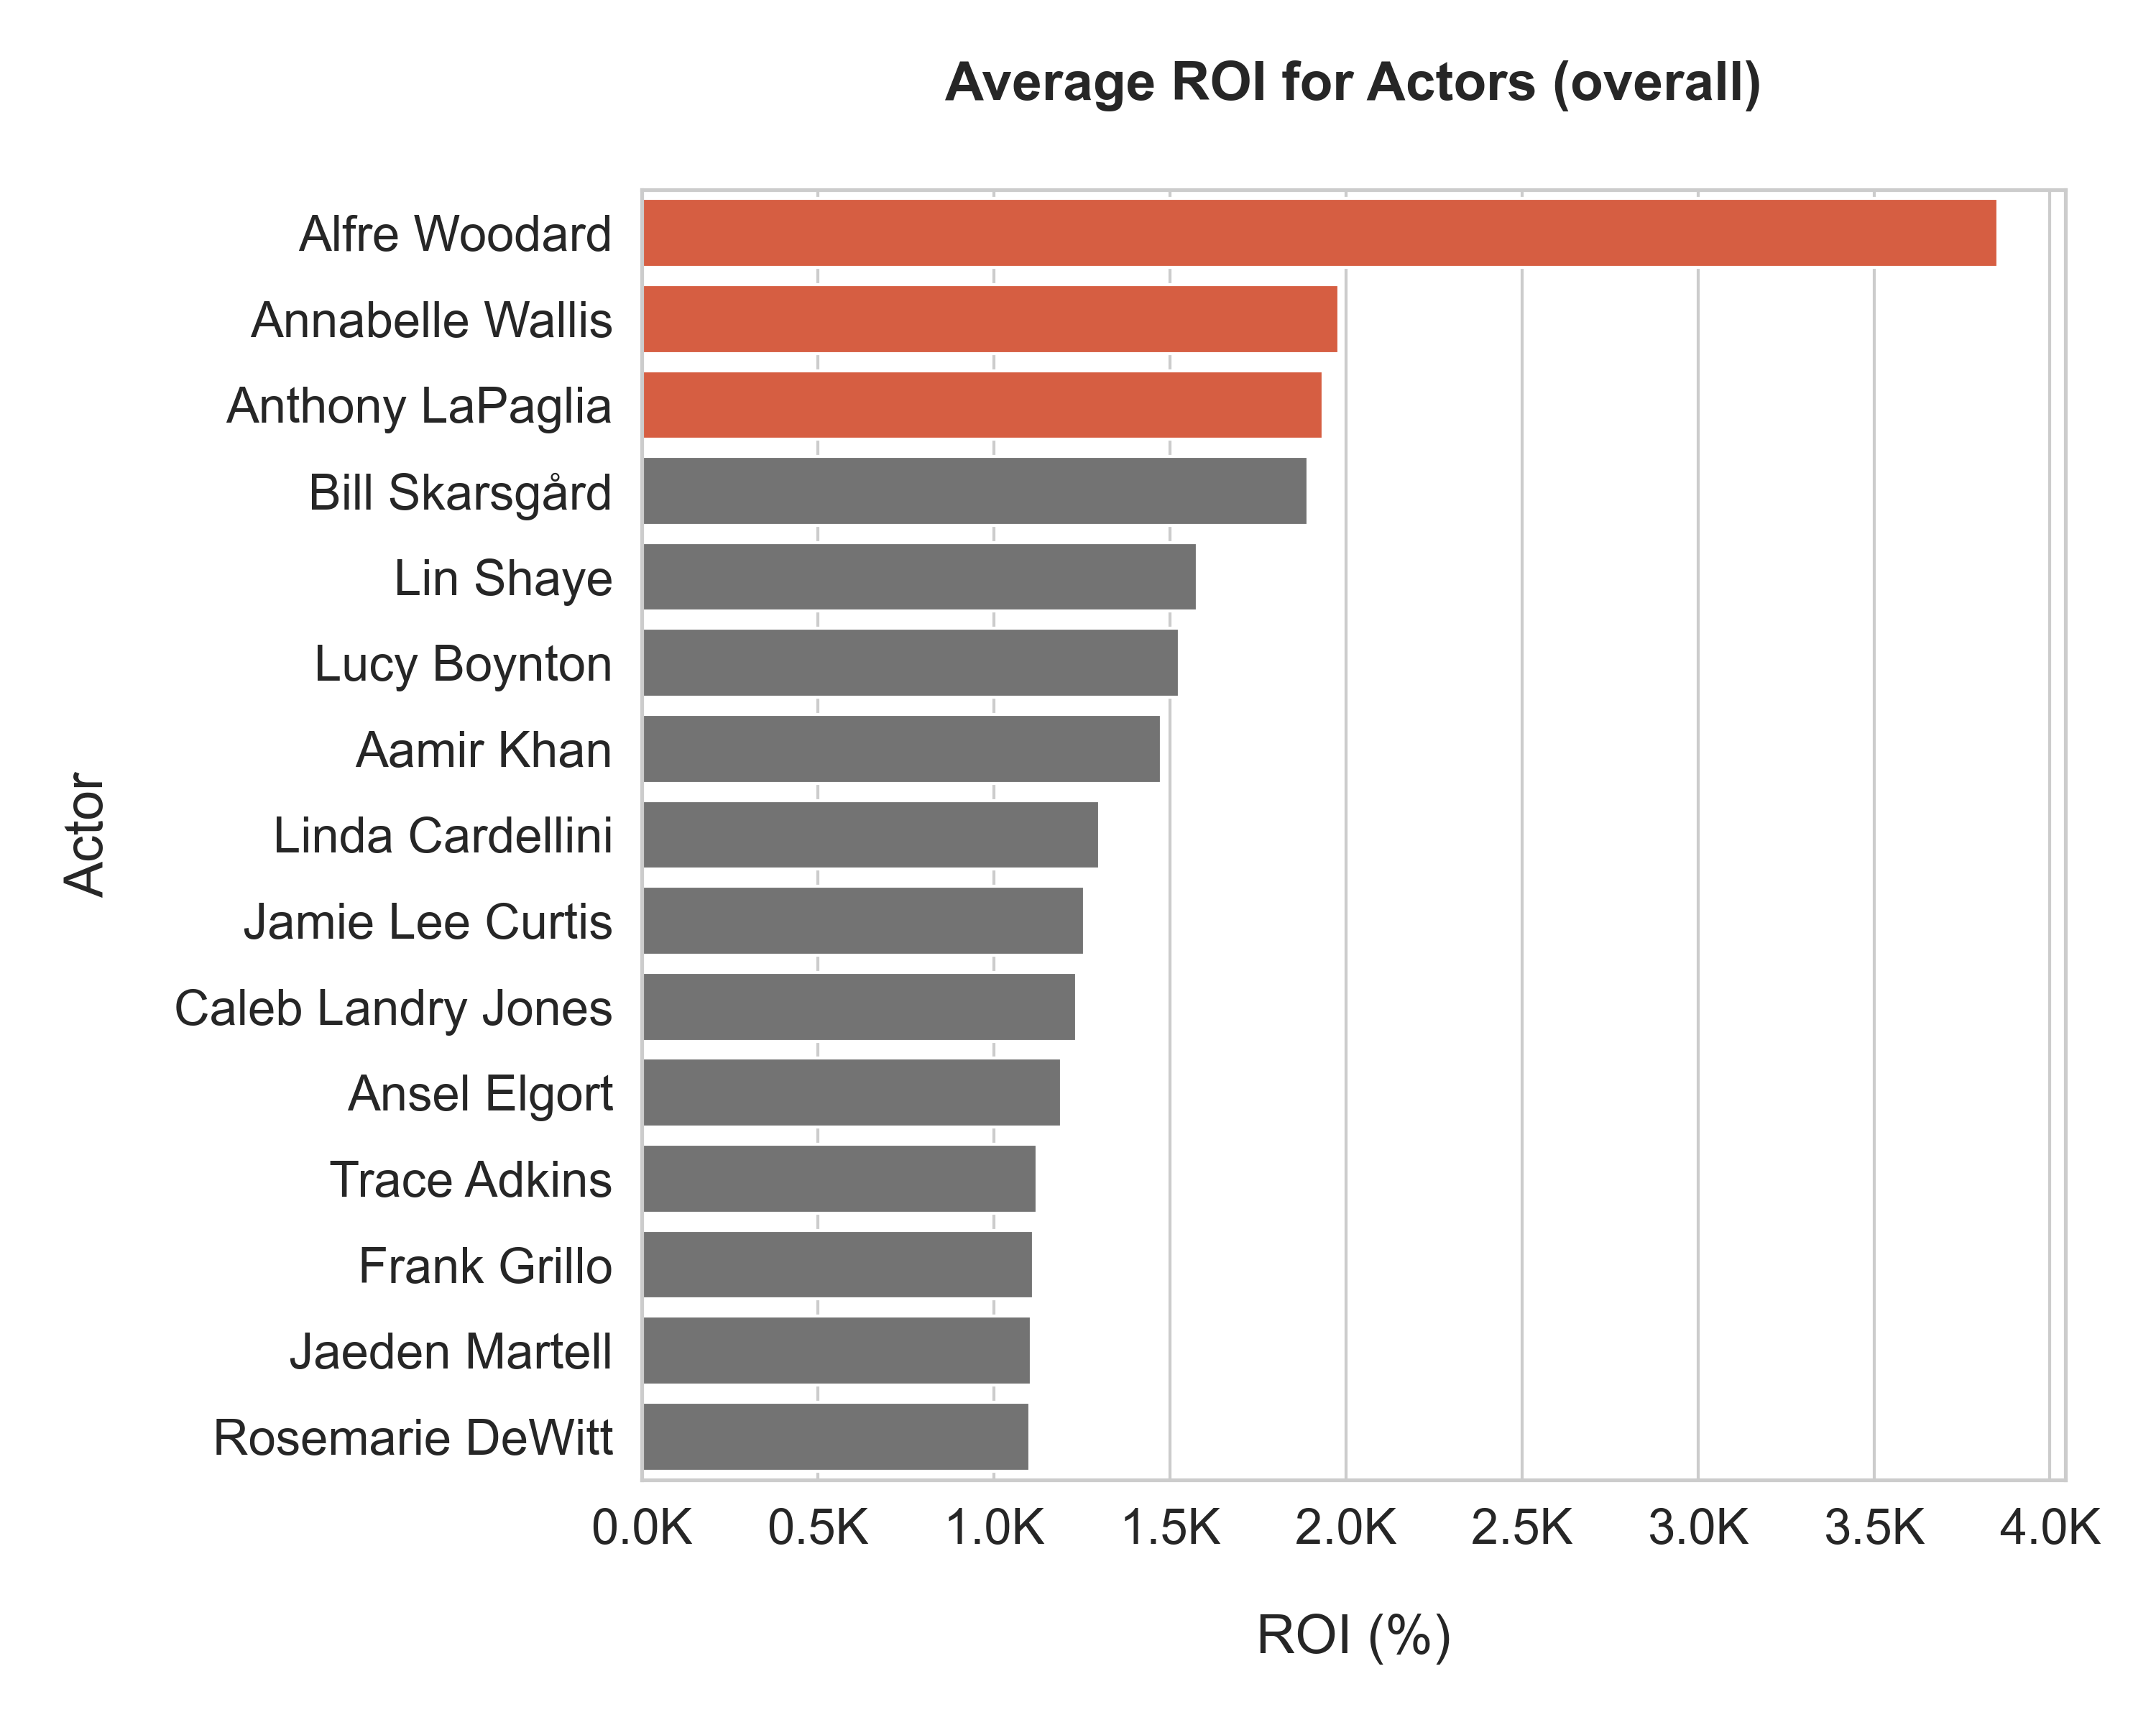
</div>

I also filtered for the highest-value actors within the Mystery genre (the highest ROI genre) alone. The top actors in this category are the same as the top actors overall, with the addition of Miranda Otto.

<div>
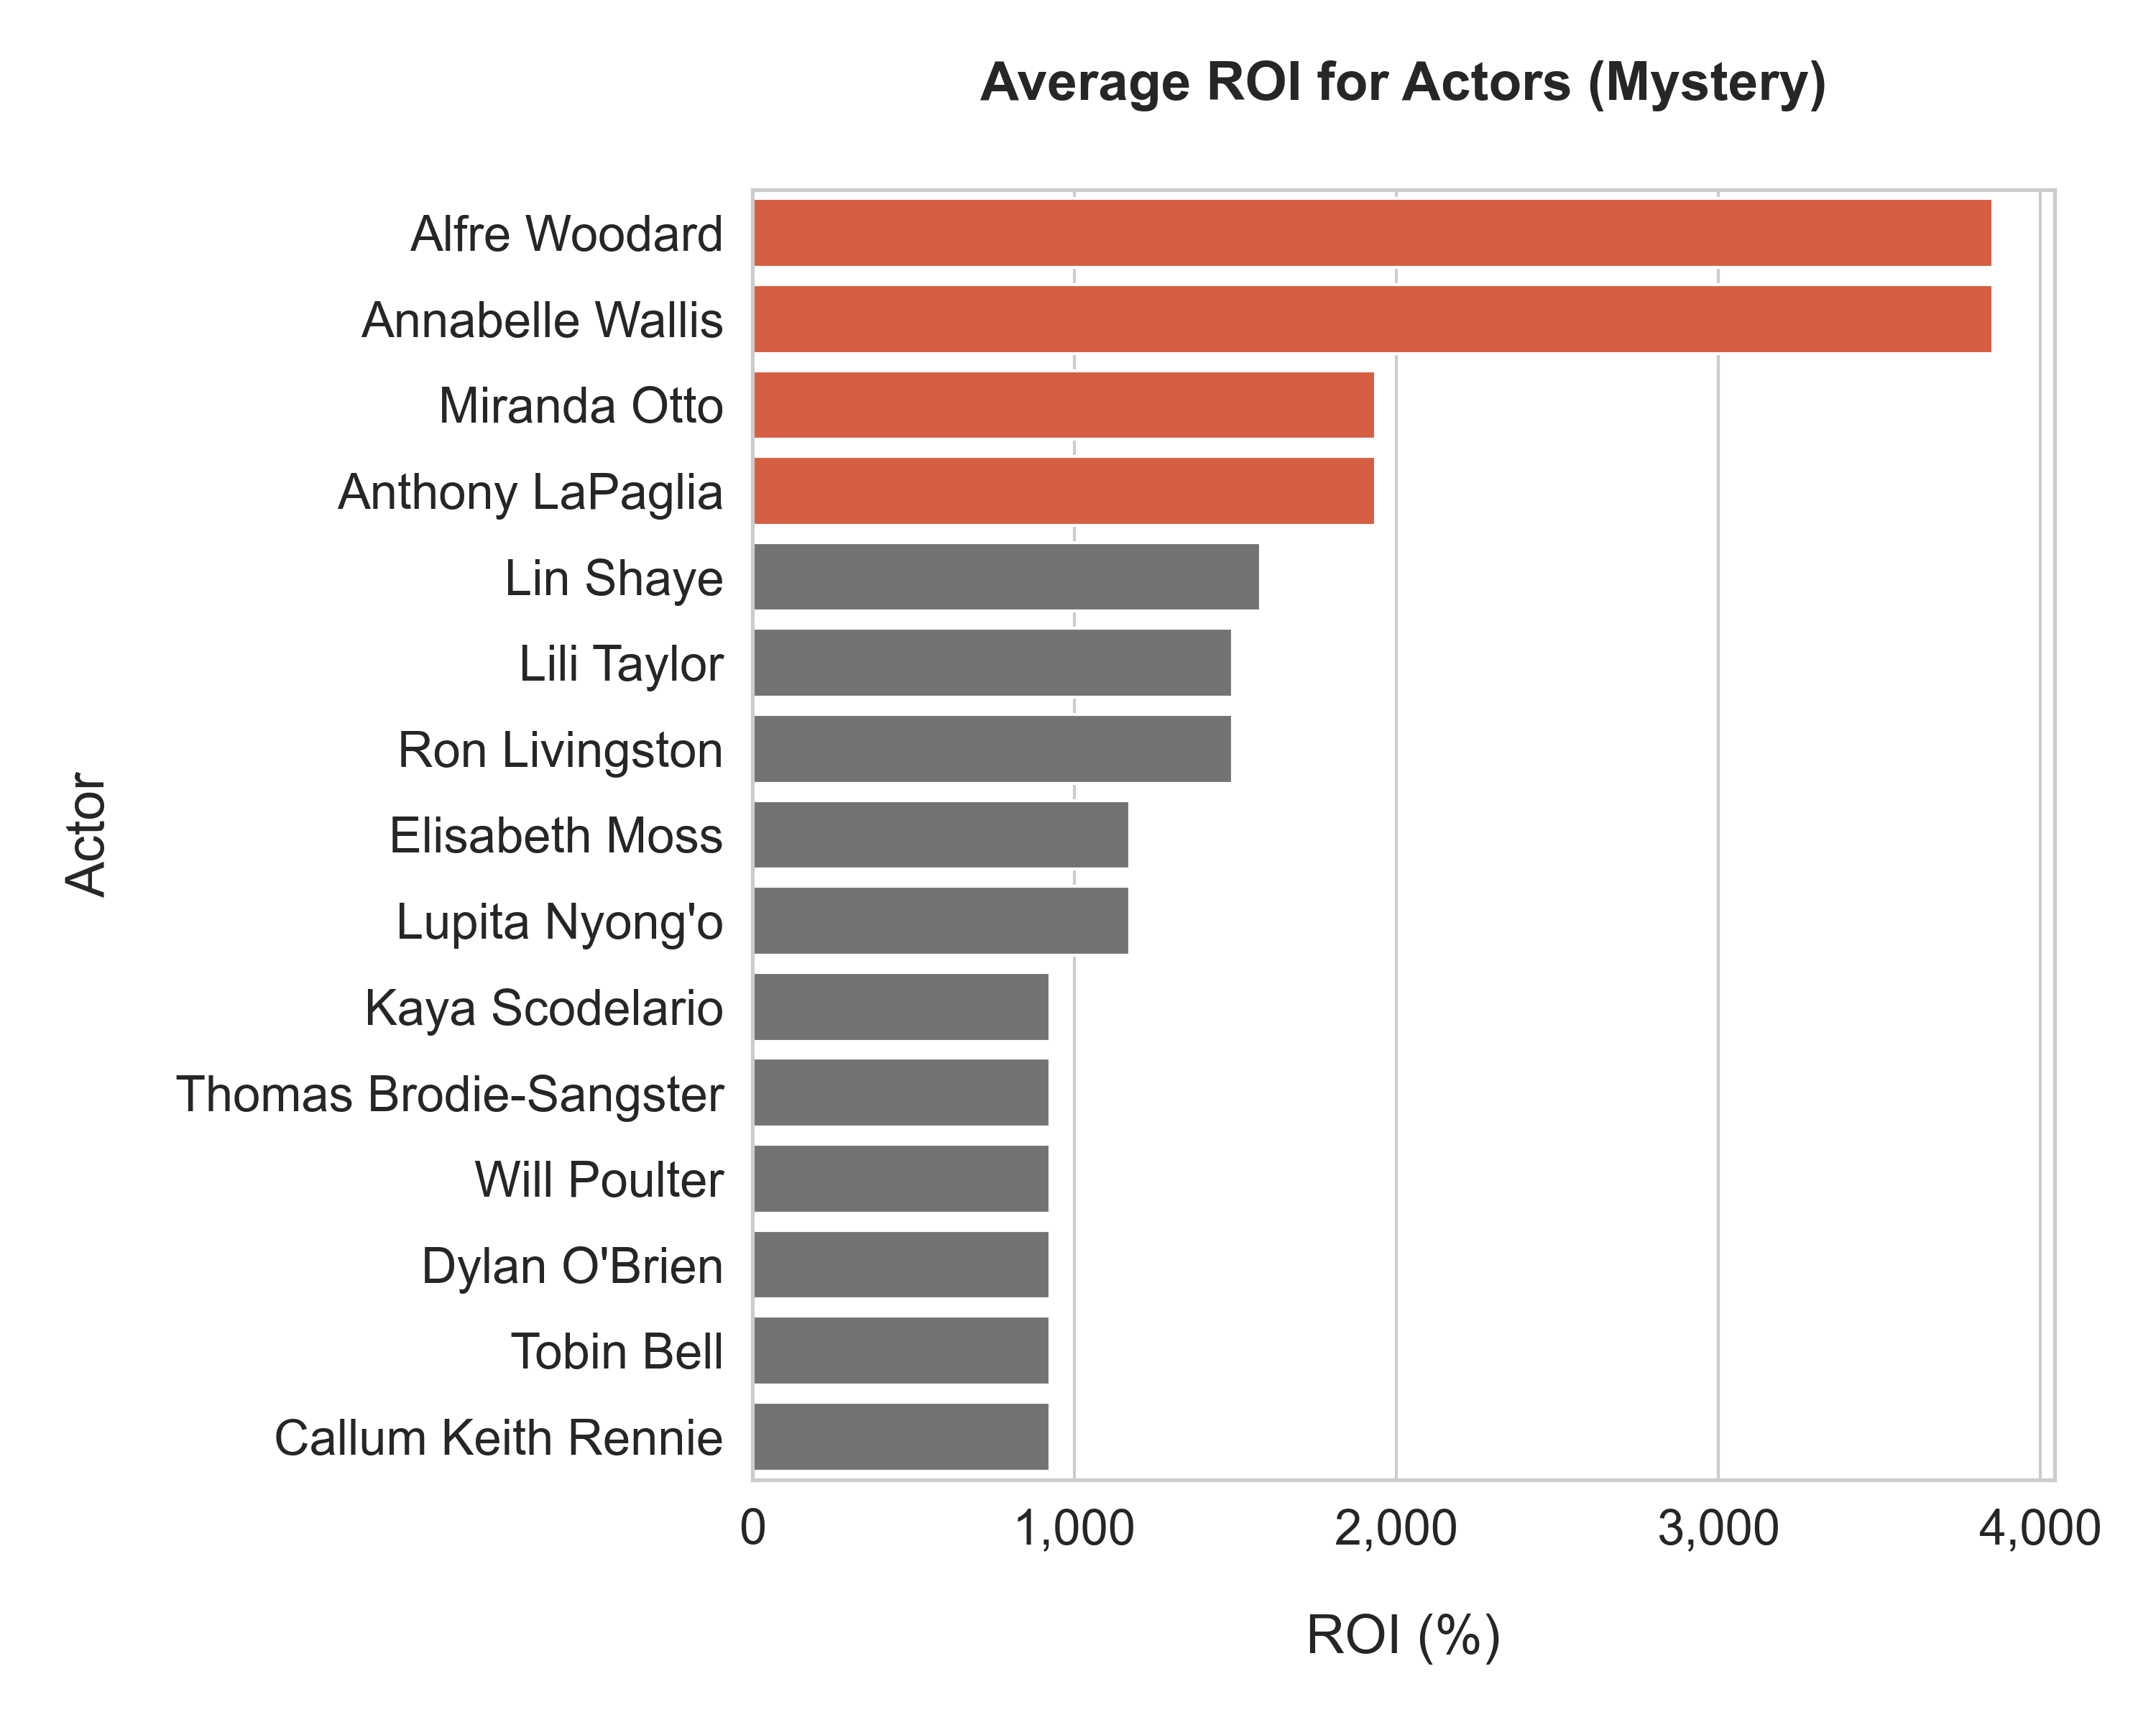
</div>

#### Directors
I filtered for directors who have directed more than 5 films, then found the average ROI of the films they have directed as a measure of director value. According to the data provided, the top 3 directors are John R. Leonetti, Kyle Balda, and James DeMonaco.

<div>
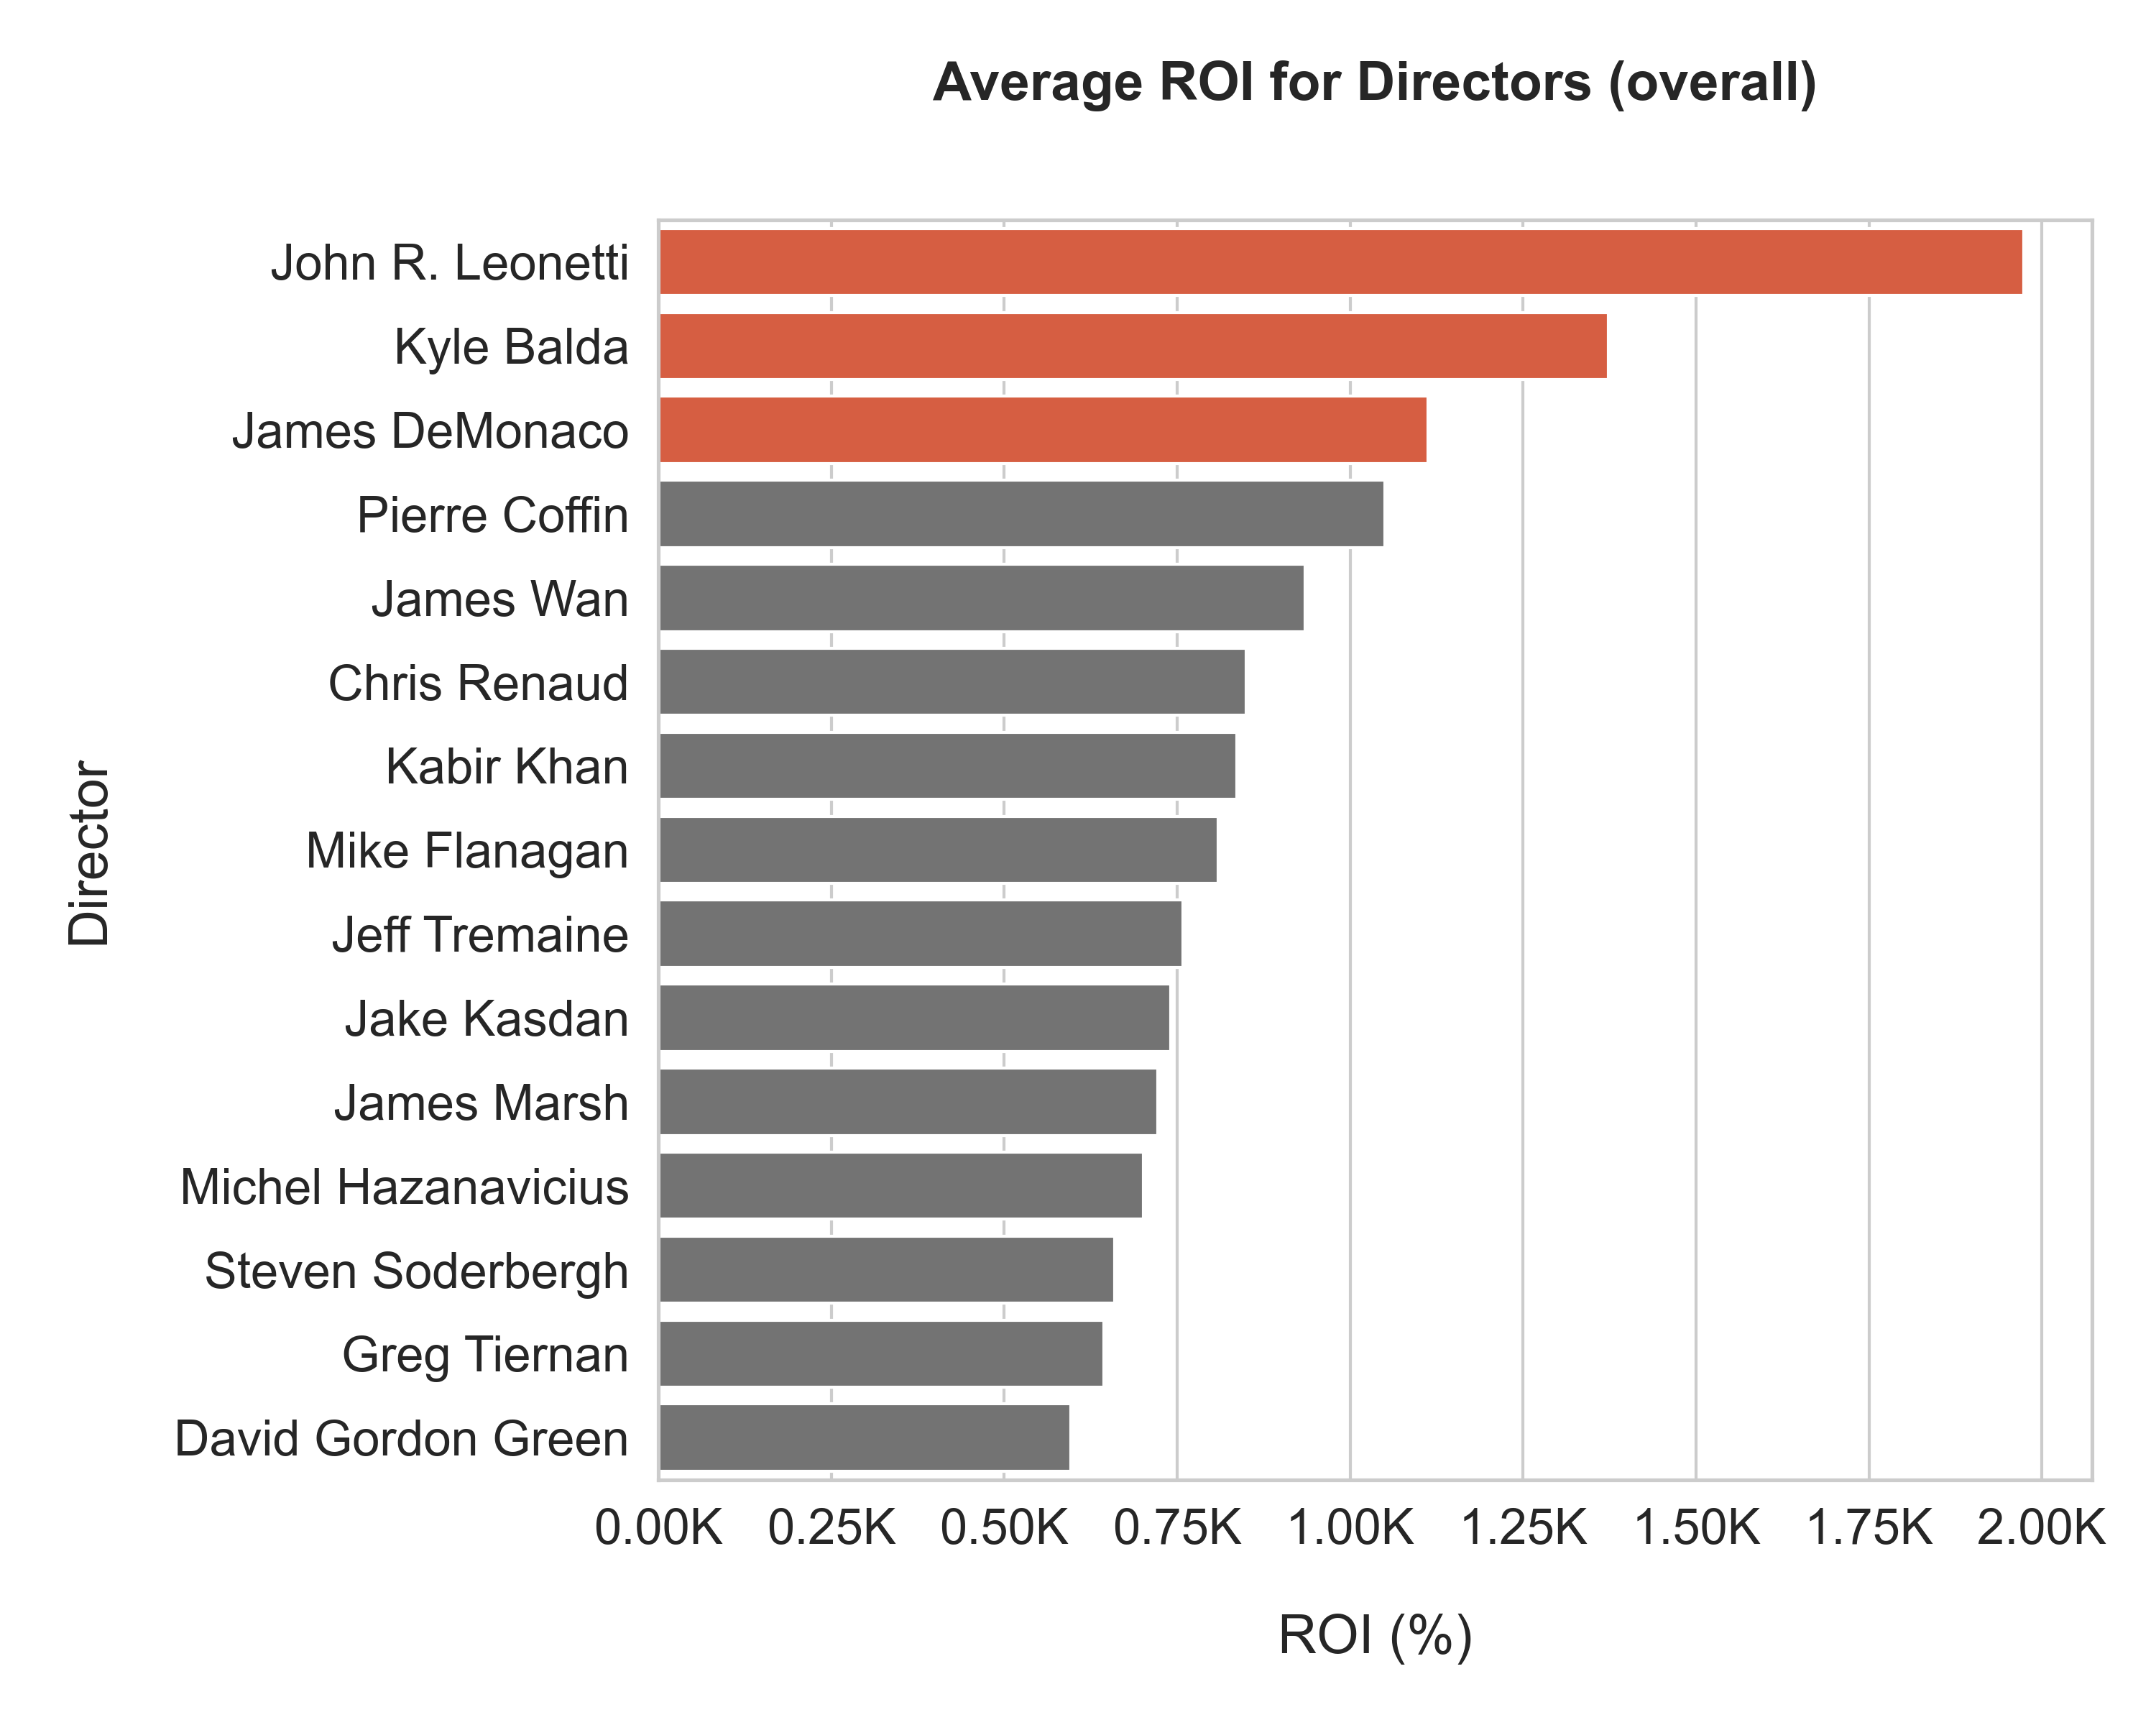
</div>

Like I did with actors, I also filtered for the highest-value directors within the Mystery genre. The top directors for Mystery are John R. Leonetti, James Wan, Mike Flanagan.

<div>
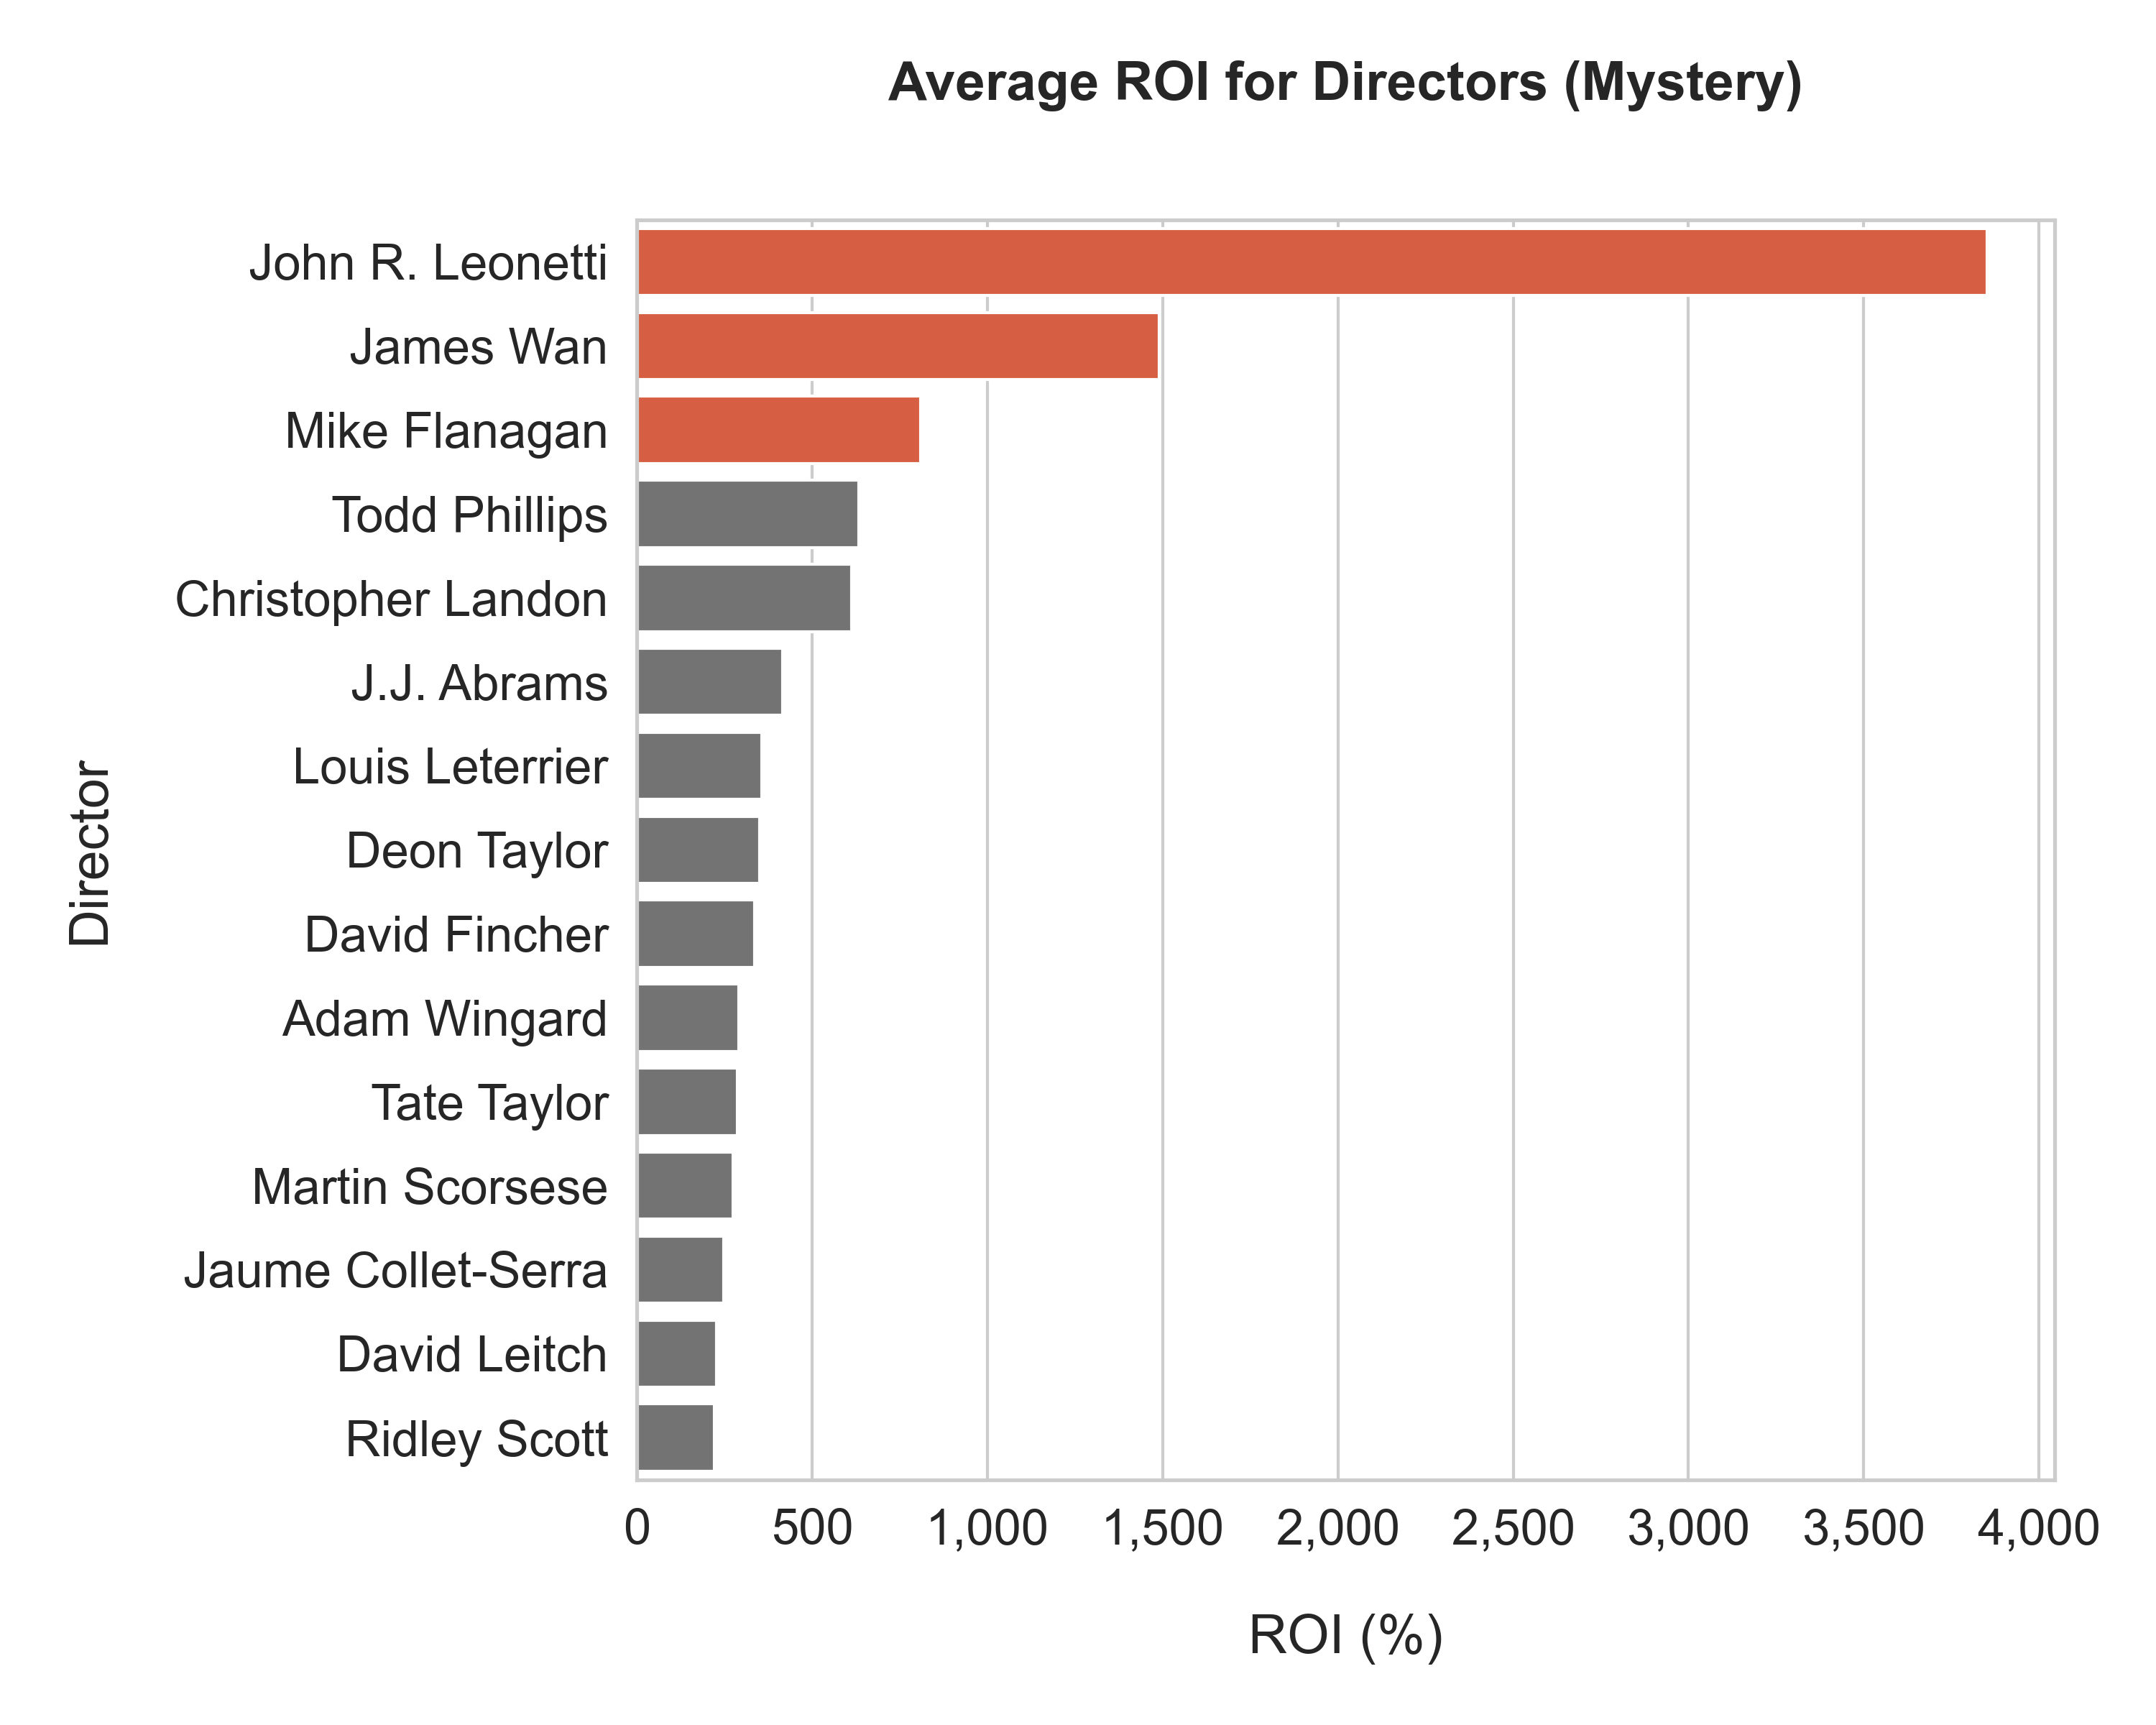
</div>

## Conclusions
***
Based on the findings of this analysis, I recommend the following for Microsoft's entry into the movie business:

**General**
- Spend 24-58 million (High Medium budget class) to start, then 58+ million in the future
- Release in the summer (May - July) or over the holidays
- Genres: Mystery, Horror, Action
- Look into hiring the following actors: Alfre Woodard, Annabelle Wallis, Anthony LaPaglia
- Work with the following directors: John R. Leonetti, Kyle Balda, James DeMonaco

**Specific (initial release)** 
- Budget of 24-58 million
- Release in July or November
- Genre: Mystery
- Top actors for Mystery: Alfre Woodard, Annabelle Wallis, Miranda Otto, Anthony LaPaglia 
- Directors for Mystery: John R. Leonetti, James Wan, Mike Flanagan



## Next Steps
***
- **Gather more monetary data (budgets and gross information).** Many titles with monetary data from The Numbers could not be matched with titles present in IMDB's database (which contained info on genres, actors, and directors). More monetary data could improve the accuracy. 
- **Model rates of production.** Microsoft would benefit from knowing what its long-term movie output should be, or how many titles to release per month or per year.
- **Look at other measures of success.** This analysis uses ROI as a measure of success for all categorical variables, like genres, actors, and diretors. Results may differ through using profit or gross figures instead.
- **Limit budget investigation to only recent releases.** For most other parts of this analysis, films were limited to releases after 2000. We live in an increasingly interconnected world, and this may affect the relationship between domestic and world wide ROI + profits.
- **Examine trends and practices for other movie studios.** More investigation can be done as far as what makes a successful movie studio, as opposed to what contributes to successful film releases.

## Note on CPI library
***
Some plots in my notebook budget analysis look different from the final plots included in this README. This is due to the fact that CPI library (used to account for inflation) ran properly for all release years until one instance, when it failed to find proper indexes for 2019 and later. 